Test on sample created with sample of neighbouring galaxies in uniform ditribution betwween -1 and 1 arcsecond around centered galaxy


- test of function to get the relevant parameters output of deblender

- Same tests with Pandas data 

New version of deblender trained with well trained VAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
import seaborn as sns
from tensorflow.keras import backend as K
import pandas as pd
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot, generator

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_alpha, denorm, delta_min, norm, load_vae_full
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, plot_rgb, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies
from tools_for_VAE.results_processing import deblender_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from importlib import reload

In [22]:
reload(plot)
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

# Function to import dense VAE

In [5]:
# Parameters
batch_size = 100
original_dim = 64*64*6

In [6]:
deblender_lsst,deblender_utils_lsst, encoder_lsst, decoder_lsst, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v6/train_6/',
                                                                                     6, folder = True)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
deblender_lsst_euclid,deblender_utils_lsst_euclid, encoder_lsst_euclid, decoder_lsst_euclid, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST_EUCLID/deblender/v5/train_7/mse/',
                                                                                            10, folder = True)

# Stamp size for plots

In [8]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

pixel_scale_lsst = 0.2

# Load test data

Load shifts

In [9]:
data_dir = '/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/test/'
root = 'galaxies_blended_20191004_test'

In [10]:
shifts = np.load(os.path.join(data_dir, root+'_010_shifts.npy'))

Load rest of test data

In [11]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_010_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
nb_blended_gal                10000 non-null int64
SNR                           10000 non-null float64
SNR_peak                      10000 non-null float64
redshift                      10000 non-null float64
moment_sigma                  10000 non-null float64
e1                            10000 non-null float64
e2                            10000 non-null float64
mag                           10000 non-null float64
mag_ir                        10000 non-null float64
closest_x                     10000 non-null float64
closest_y                     10000 non-null float64
closest_redshift              10000 non-null float64
closest_moment_sigma          10000 non-null float64
closest_e1                    10000 non-null float64
closest_e2                    10000 non-null float64
closest_mag                   10000 non-null float64
closest_mag_ir                10000 non-null f

In [13]:
df.head()

nb_blended_gal         SNR  SNR_peak  redshift  moment_sigma        e1  \
0               2   40.538941  0.056681    0.2264      2.175257 -0.026552   
1               1   43.345762  0.074422    0.0219      1.716866  0.052383   
2               1   33.746774  0.046207    1.7441      2.249600 -0.136790   
3               4  318.147299  0.300836    0.1662      3.670524 -0.203740   
4               3   85.112223  0.087837    0.7961      3.130349  0.088898   

         e2        mag    mag_ir  closest_x  ...  closest_redshift  \
0  0.049214  26.373794 -0.382880  -0.410607  ...            1.4953   
1 -0.153286  26.482803 -0.515679   0.000000  ...            0.0219   
2 -0.382712  26.532654 -1.730437   0.000000  ...            1.7441   
3  0.175440  23.508441 -3.215953  -0.121300  ...            1.1730   
4 -0.052272  25.171944 -2.594629   0.740828  ...            1.3624   

   closest_moment_sigma  closest_e1  closest_e2  closest_mag  closest_mag_ir  \
0              1.590679    0.143143    0.221511    29.567116       -2.062741   
1              1.716866    0.052383   -0.153286    26.482803       -0.515679   
2              2.249600   -0.136790   -0.382712    26.532654       -1.730437   
3              2.081314   -0.079631    0.175564    26.699008       -2.977022   
4              1.618648   -0.258741    0.174950    27.748370       -0.520251   

   blendedness_total_lsst  blendedness_total_euclid  blendedness_closest_lsst  \
0                0.021239                  0.159265                  0.312474   
1                     NaN                       NaN                       NaN   
2                     NaN                       NaN                       NaN   
3                0.121712                  0.378343                  0.732641   
4                0.115619                  0.139450                  0.481647   

   blendedness_closest_euclid  
0                    0.055102  
1                         NaN  
2                         NaN  
3                    0.407208  
4                    0.220966  

[5 rows x 21 columns]

In [14]:
df.describe()

nb_blended_gal           SNR      SNR_peak      redshift  moment_sigma  \
count      10000.0000  10000.000000  10000.000000  10000.000000  10000.000000   
mean           2.4842    111.362093      0.171691      0.935891      2.156429   
std            1.1236    230.184429      0.437368      0.723894      0.523718   
min            1.0000      1.352263      0.001834      0.006500      1.488476   
25%            1.0000     23.411316      0.035635      0.418500      1.786459   
50%            2.0000     42.474725      0.062798      0.746500      2.027096   
75%            3.0000     92.411921      0.131158      1.164200      2.358661   
max            4.0000   3050.687094      7.684160      5.197400      5.651824   

                 e1            e2           mag        mag_ir     closest_x  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.001309      0.000864     26.105825     -1.898260      0.000173   
std        0.285572      0.282458      1.432332      1.366535      0.409938   
min       -1.336012     -1.352665     20.037094     -7.306114     -0.999226   
25%       -0.166515     -0.162834     25.359627     -2.752097     -0.225488   
50%        0.001238      0.001659     26.379427     -1.752228      0.000000   
75%        0.163062      0.161173     27.108973     -0.918181      0.231861   
max        1.554135      1.914536     29.792827      0.930522      0.999047   

       ...  closest_redshift  closest_moment_sigma    closest_e1  \
count  ...      10000.000000          10000.000000  10000.000000   
mean   ...          1.174166              1.922571     -0.000095   
std    ...          0.745301              0.351231      0.305348   
min    ...          0.021900              1.488475     -1.832280   
25%    ...          0.671900              1.686340     -0.191019   
50%    ...          0.990750              1.826825     -0.000237   
75%    ...          1.487100              2.046902      0.189207   
max    ...          5.208000              5.546958      1.571674   

         closest_e2   closest_mag  closest_mag_ir  blendedness_total_lsst  \
count  10000.000000  10000.000000    10000.000000             7421.000000   
mean      -0.000954     27.292115       -1.203189                0.219586   
std        0.309166      0.978652        1.226625                0.145039   
min       -1.574734     20.037094       -7.306114                0.000189   
25%       -0.195832     26.880209       -1.910334                0.097044   
50%        0.002850     27.443691       -0.990602                0.200227   
75%        0.192286     27.869905       -0.301550                0.322372   
max        1.613503     29.792827        0.946252                0.769525   

       blendedness_total_euclid  blendedness_closest_lsst  \
count               7421.000000               7421.000000   
mean                   0.162084                  0.545578   
std                    0.167079                  0.231570   
min                    0.000157                  0.043904   
25%                    0.034496                  0.353381   
50%                    0.102970                  0.544421   
75%                    0.237053                  0.738272   
max                    0.919790                  0.992873   

       blendedness_closest_euclid  
count                 7421.000000  
mean                     0.269076  
std                      0.233488  
min                      0.000678  
25%                      0.073001  
50%                      0.198105  
75%                      0.420638  
max                      0.972179  

[8 rows x 21 columns]

# Batch Generation

In [14]:
list_of_samples = [data_dir+'galaxies_blended_20191004_test_010_images.npy']

In [15]:
bands_lsst = [4,5,6,7,8,9]

In [16]:
batch_gen = generator.BatchGenerator(bands_lsst, list_of_samples,total_sample_size=10000, batch_size= 100, trainval_or_test = 'test', do_norm = True, list_of_weights_e = None, shifts = shifts)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [17]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [18]:
batch_gen_lsst_euclid = generator.BatchGenerator(bands_lsst_euclid, list_of_samples,total_sample_size=10000, batch_size= 100, trainval_or_test = 'test', do_norm = True, list_of_weights_e = None, shifts = shifts)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


# LSST only

In [19]:
stamp_size_plot = int(stamp_size /2)

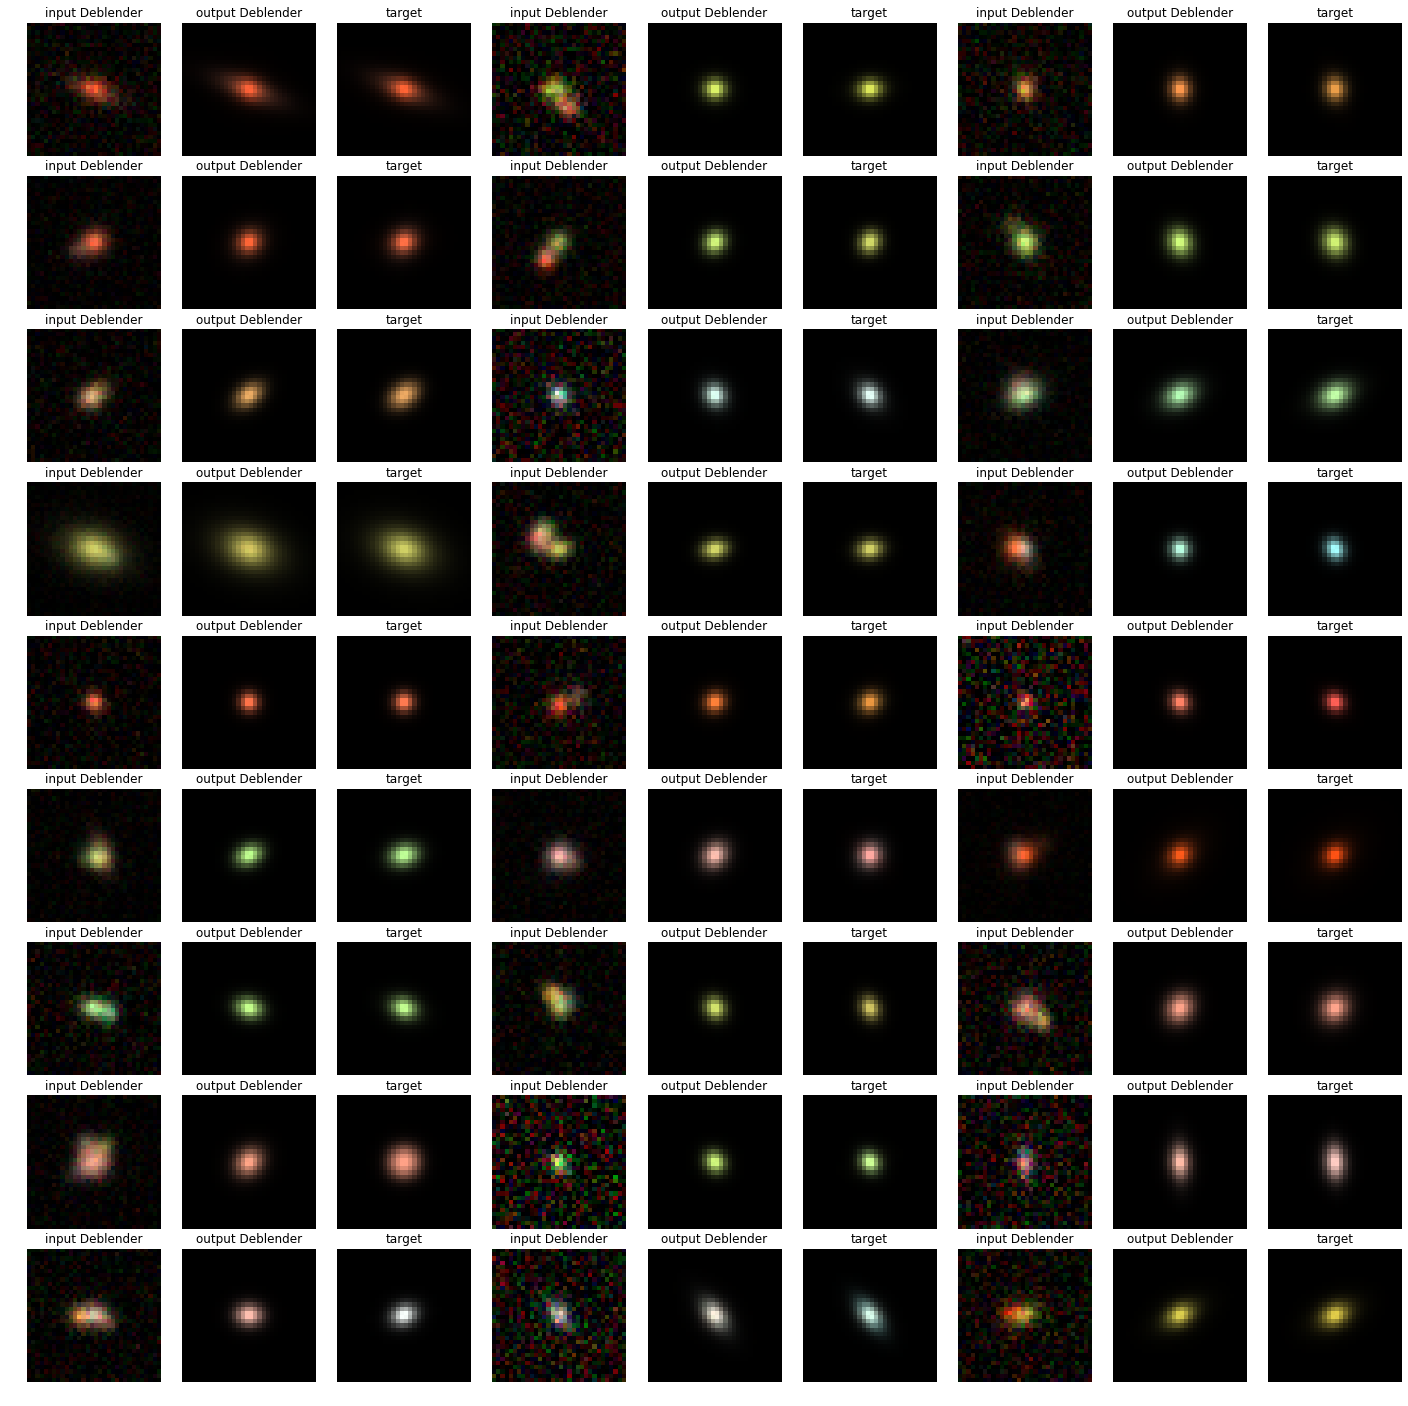

In [20]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender_lsst.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands_lsst, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot.plot_rgb_lsst(input_noisy[indices[i*N_plot+j]],stamp_size_plot, axes[i,j])
        plot.plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size_plot, axes[i,j+1])
        plot.plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size_plot, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

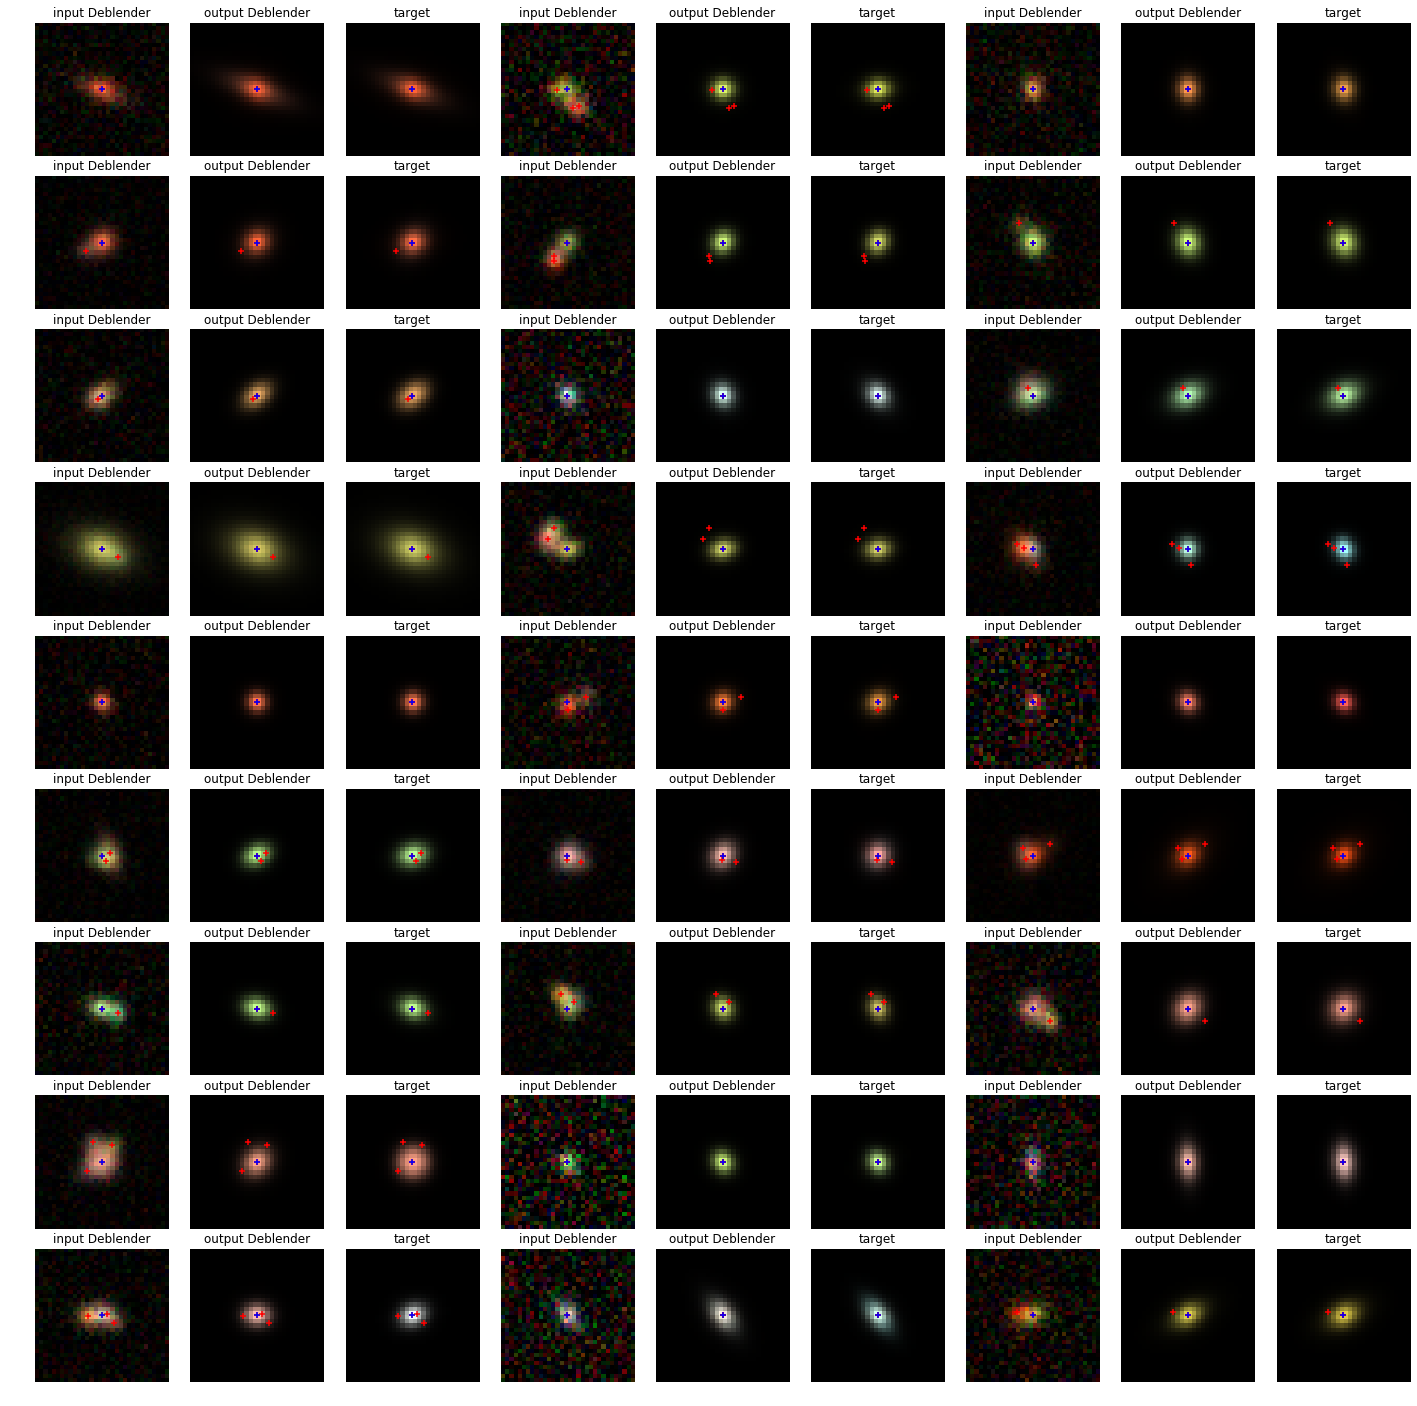

In [23]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot.plot_rgb(input_noisy[indices[i*N_plot+j]], bands = [4,2,1],ax= axes[i,j], band_first = False,zoom = 2, shifts = input_lsst[3][indices[i*N_plot+j]]/pixel_scale_lsst)
        plot.plot_rgb(output_deblender_lsst[indices[i*N_plot+j]], bands = [4,2,1],ax= axes[i,j+1], band_first = False,zoom = 2, shifts = input_lsst[3][indices[i*N_plot+j]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i*N_plot+j]], bands = [4,2,1],ax= axes[i,j+2], band_first = False,zoom = 2, shifts = input_lsst[3][indices[i*N_plot+j]]/pixel_scale_lsst)

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

## Shape reproduction

In [24]:
N = 100
batch_size = 100

ellipticities_lsst,e_beta_lsst, flux_in_lsst, flux_out_lsst, indices_lsst = deblender_processing(deblender_lsst, batch_gen,bands_lsst,2,stamp_size, N, batch_size)

In [29]:
delta_e1_lsst = ellipticities_lsst[:,1,0] - ellipticities_lsst[:,0,0]
delta_e2_lsst = ellipticities_lsst[:,1,1] - ellipticities_lsst[:,0,1]
delta_e_lsst =  e_beta_lsst[:,1,0] - e_beta_lsst[:,0,0]

Plots

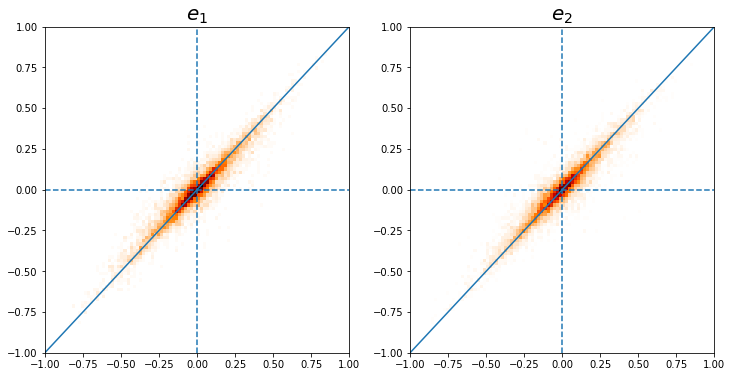

In [29]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst[:,0,i], ellipticities_lsst[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    

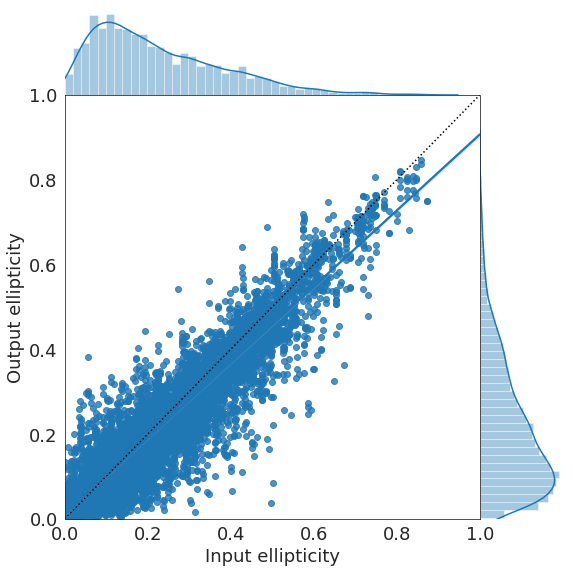

In [31]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')

In [32]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0])

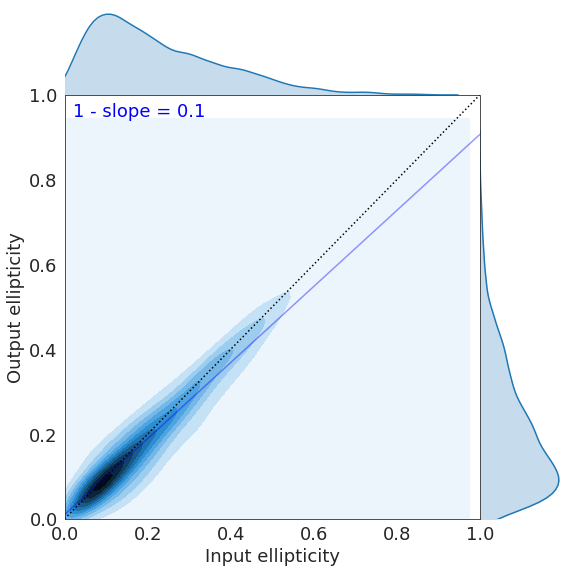

In [33]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst*np.linspace(0, 1)+intercept_lsst, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst, 2)), color='b')

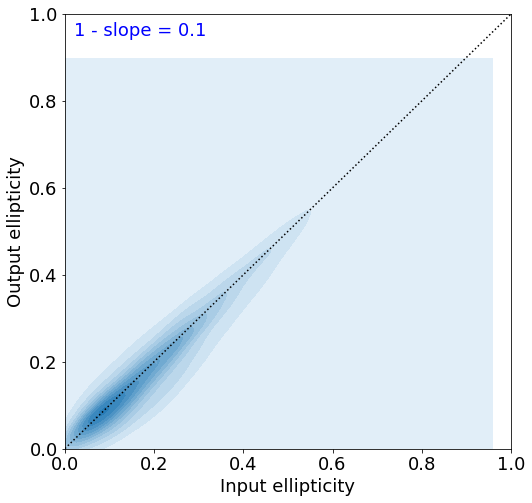

In [77]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,1, figsize=(8,8))

with sns.axes_style('white'):
            
            g = sns.kdeplot(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], kind='kde',height =8,
                              space=0, shade = True)

            g.set_xlabel('Input ellipticity')
            g.set_ylabel('Output ellipticity')
            g.set_xlim(0, 1)
            g.set_ylim(0, 1)
            g.plot(np.linspace(-1, 1),np.linspace(-1, 1), ':k')
            g.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst, 2)), color='b')

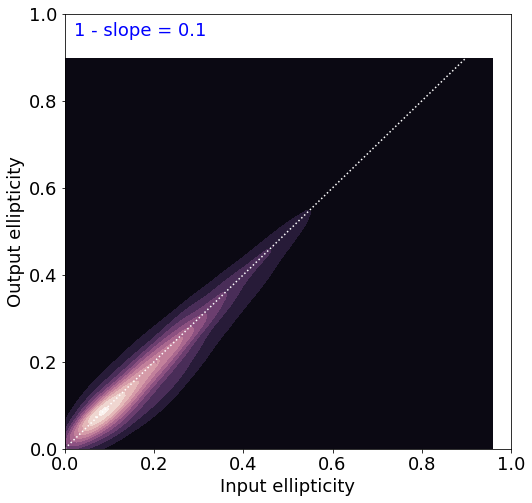

In [67]:
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)

import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,1, figsize=(8,8))

with sns.axes_style('white'):
            
            g = sns.kdeplot(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], kind='kde',height =8,cmap = cmap,
                              space=0,shade = True)

            g.set_xlabel('Input ellipticity')
            g.set_ylabel('Output ellipticity')
            g.set_xlim(0, 1)
            g.set_ylim(0, 1)
            g.plot(np.linspace(-1, 1),np.linspace(-1, 1), ':k', color = 'w')
            g.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst, 2)), color='b')


Text(-0.47, 800, 'median of histo = -0.009')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


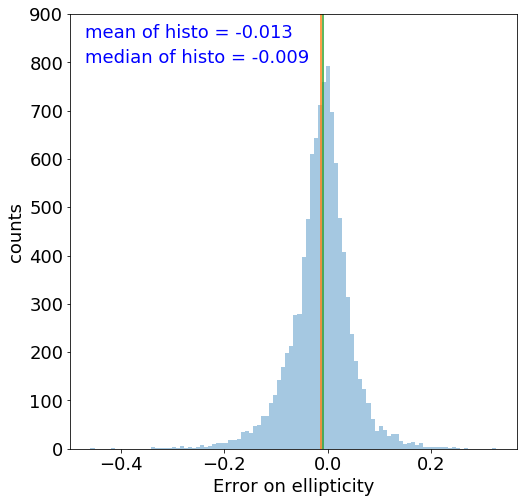

In [34]:
fig, axes = plt.subplots(1,1, figsize=(8,8))

a = sns.distplot(delta_e_lsst, bins = 100, hist = True, kde = False)
a.set_xlabel('Error on ellipticity')
a.set_ylabel('counts')
a.plot(np.ones((50,))*np.mean(delta_e_lsst),np.linspace(0, 1000))
a.plot(np.ones((50,))*np.median(delta_e_lsst),np.linspace(0, 1000))

a.set_ylim(0, 900)
a.text(-0.47, 850, 'mean of histo = '+str(round(np.mean(delta_e_lsst), 3)), color='b')
a.text(-0.47, 800, 'median of histo = '+str(round(np.median(delta_e_lsst), 3)), color='b')

## Flux reproduction

### In R band

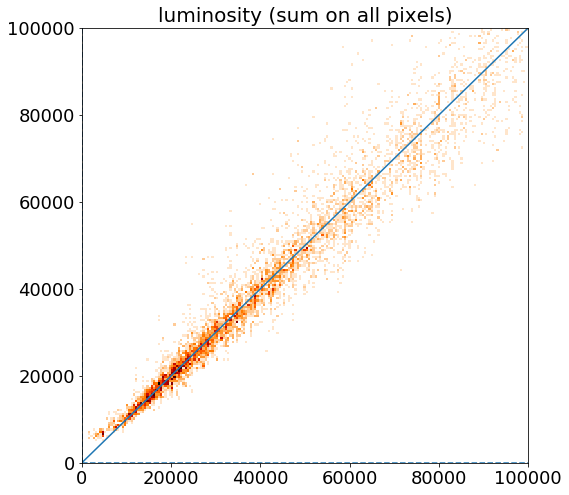

In [35]:
import matplotlib as mpl

max_lum = np.max(flux_in_lsst)

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(flux_in_lsst, flux_out_lsst, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

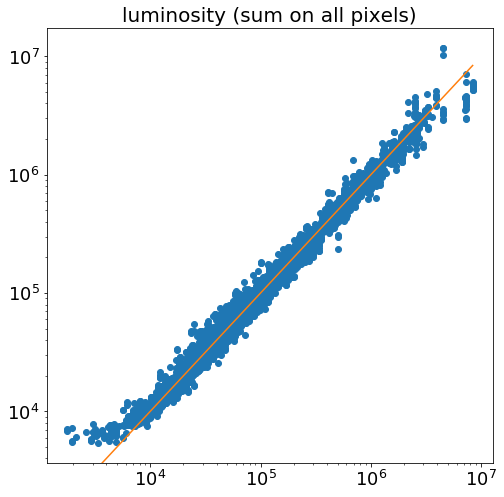

In [36]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(flux_in_lsst)
axes.plot(flux_in_lsst, flux_out_lsst,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
#axes.set_xlim(0,emax)
#axes.set_ylim(0,emax)
axes.set_xscale('log')
axes.set_yscale('log')

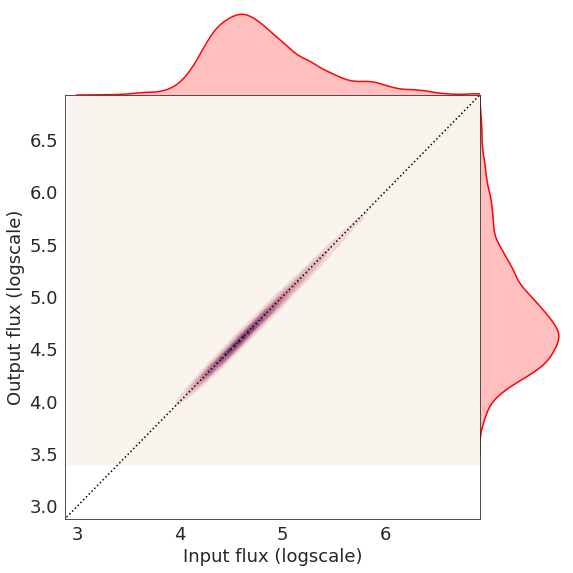

In [37]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst), np.log10(flux_out_lsst), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))], ylim=[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst))), ':k')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'kind', 'height', 'space'
  s)


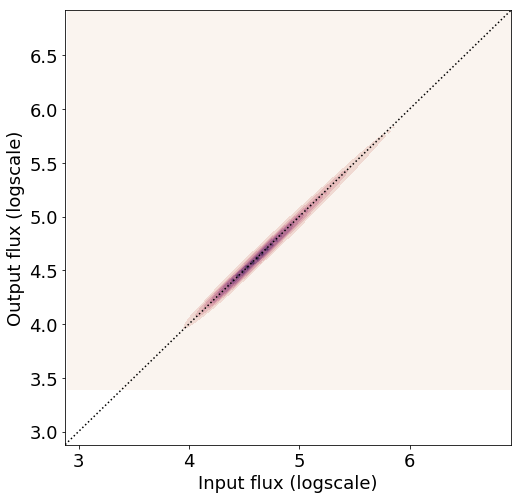

In [38]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,1, figsize=(8,8))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.kdeplot(np.log10(flux_in_lsst), np.log10(flux_out_lsst), kind='kde',height =8,
                              cmap=cmap,color = 'red', space=0, shade = True)
            g.set_xlabel('Input flux (logscale)')
            g.set_ylabel('Output flux (logscale)')
            g.set_xlim(np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst)))
            g.set_ylim(np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst)))
            g.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst))), ':k')

### Flux in all bands

In [53]:
N = 100

generator = batch_gen
deblender = deblender_lsst
bands = bands_lsst
im_size = stamp_size
batch_size = 100

flux_in_all_bands_lsst = np.empty([N,batch_size,6],dtype='float32')
flux_out_all_bands_lsst= np.empty([N,batch_size,6], dtype='float32')
for j in range(N):
    input_vae = generator.__getitem__(2)
    output_vae = deblender.predict(input_vae[0], batch_size = batch_size)
    output_vae = utils.denorm(output_vae, bands, channel_last = True)
    input_noiseless = utils.denorm(input_vae[1], bands, channel_last = True)

    for i in range (len(input_vae[0])):
        for k in range (len(input_noiseless[i][0,0])):
            # Measurement of fluxes
            mask = plot.createCircularMask(im_size,im_size,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,k].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,k].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            flux_in_all_bands_lsst[j,i,k] = np.sum(masked_img_in_simple)
            flux_out_all_bands_lsst[j,i,k] = np.sum(masked_img_out_simple)


In [54]:
flux_in_all_bands_lsst = np.concatenate(flux_in_all_bands_lsst, axis =0)
flux_out_all_bands_lsst = np.concatenate(flux_out_all_bands_lsst, axis =0)

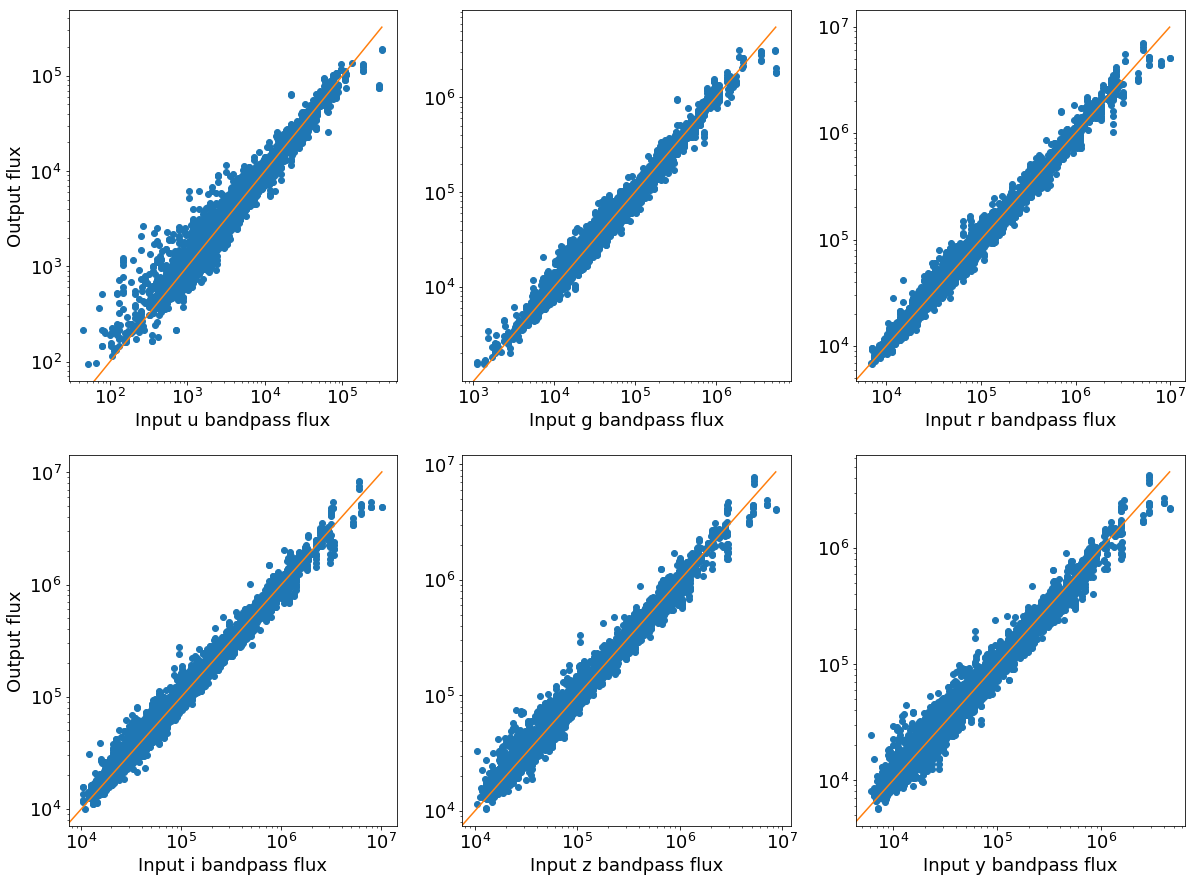

In [55]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

N = 3
fig, axes = plt.subplots(2,N, figsize=(20,15))

filter_names_all = 'ugrizy'

j = 0
i = 0

for filter_name in filter_names_all:
    ax = axes[j,i]
    ax.plot(flux_in_all_bands_lsst[:,i+j*N], flux_out_all_bands_lsst[:,i+j*N],'o')
    emax = np.max(flux_in_all_bands_lsst[:,i+j*N])
    ax.plot([-emax,+emax],[-emax,+emax])
    ax.spines['bottom']
    ax.spines['right']
    ax.spines['left']
    ax.spines['top']
    ax.xaxis.label
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    if i == 0 or i == 3:
        ax.set_ylabel('Output flux')
    ax.set_xlabel('Input {0} bandpass flux'.format(filter_name))
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 2:
        j = 1
        i = 0
    else:
        i+=1

###### Corner plot for latent space

In [51]:
batch_size = 100

In [52]:
a = batch_gen.__getitem__(2)
output_enc = encoder.predict(a[0], batch_size = batch_size)

In [53]:
latent_dim =32
epsilon_std = 1.0

In [54]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon


z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

In [55]:
z = np.concatenate(z, axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


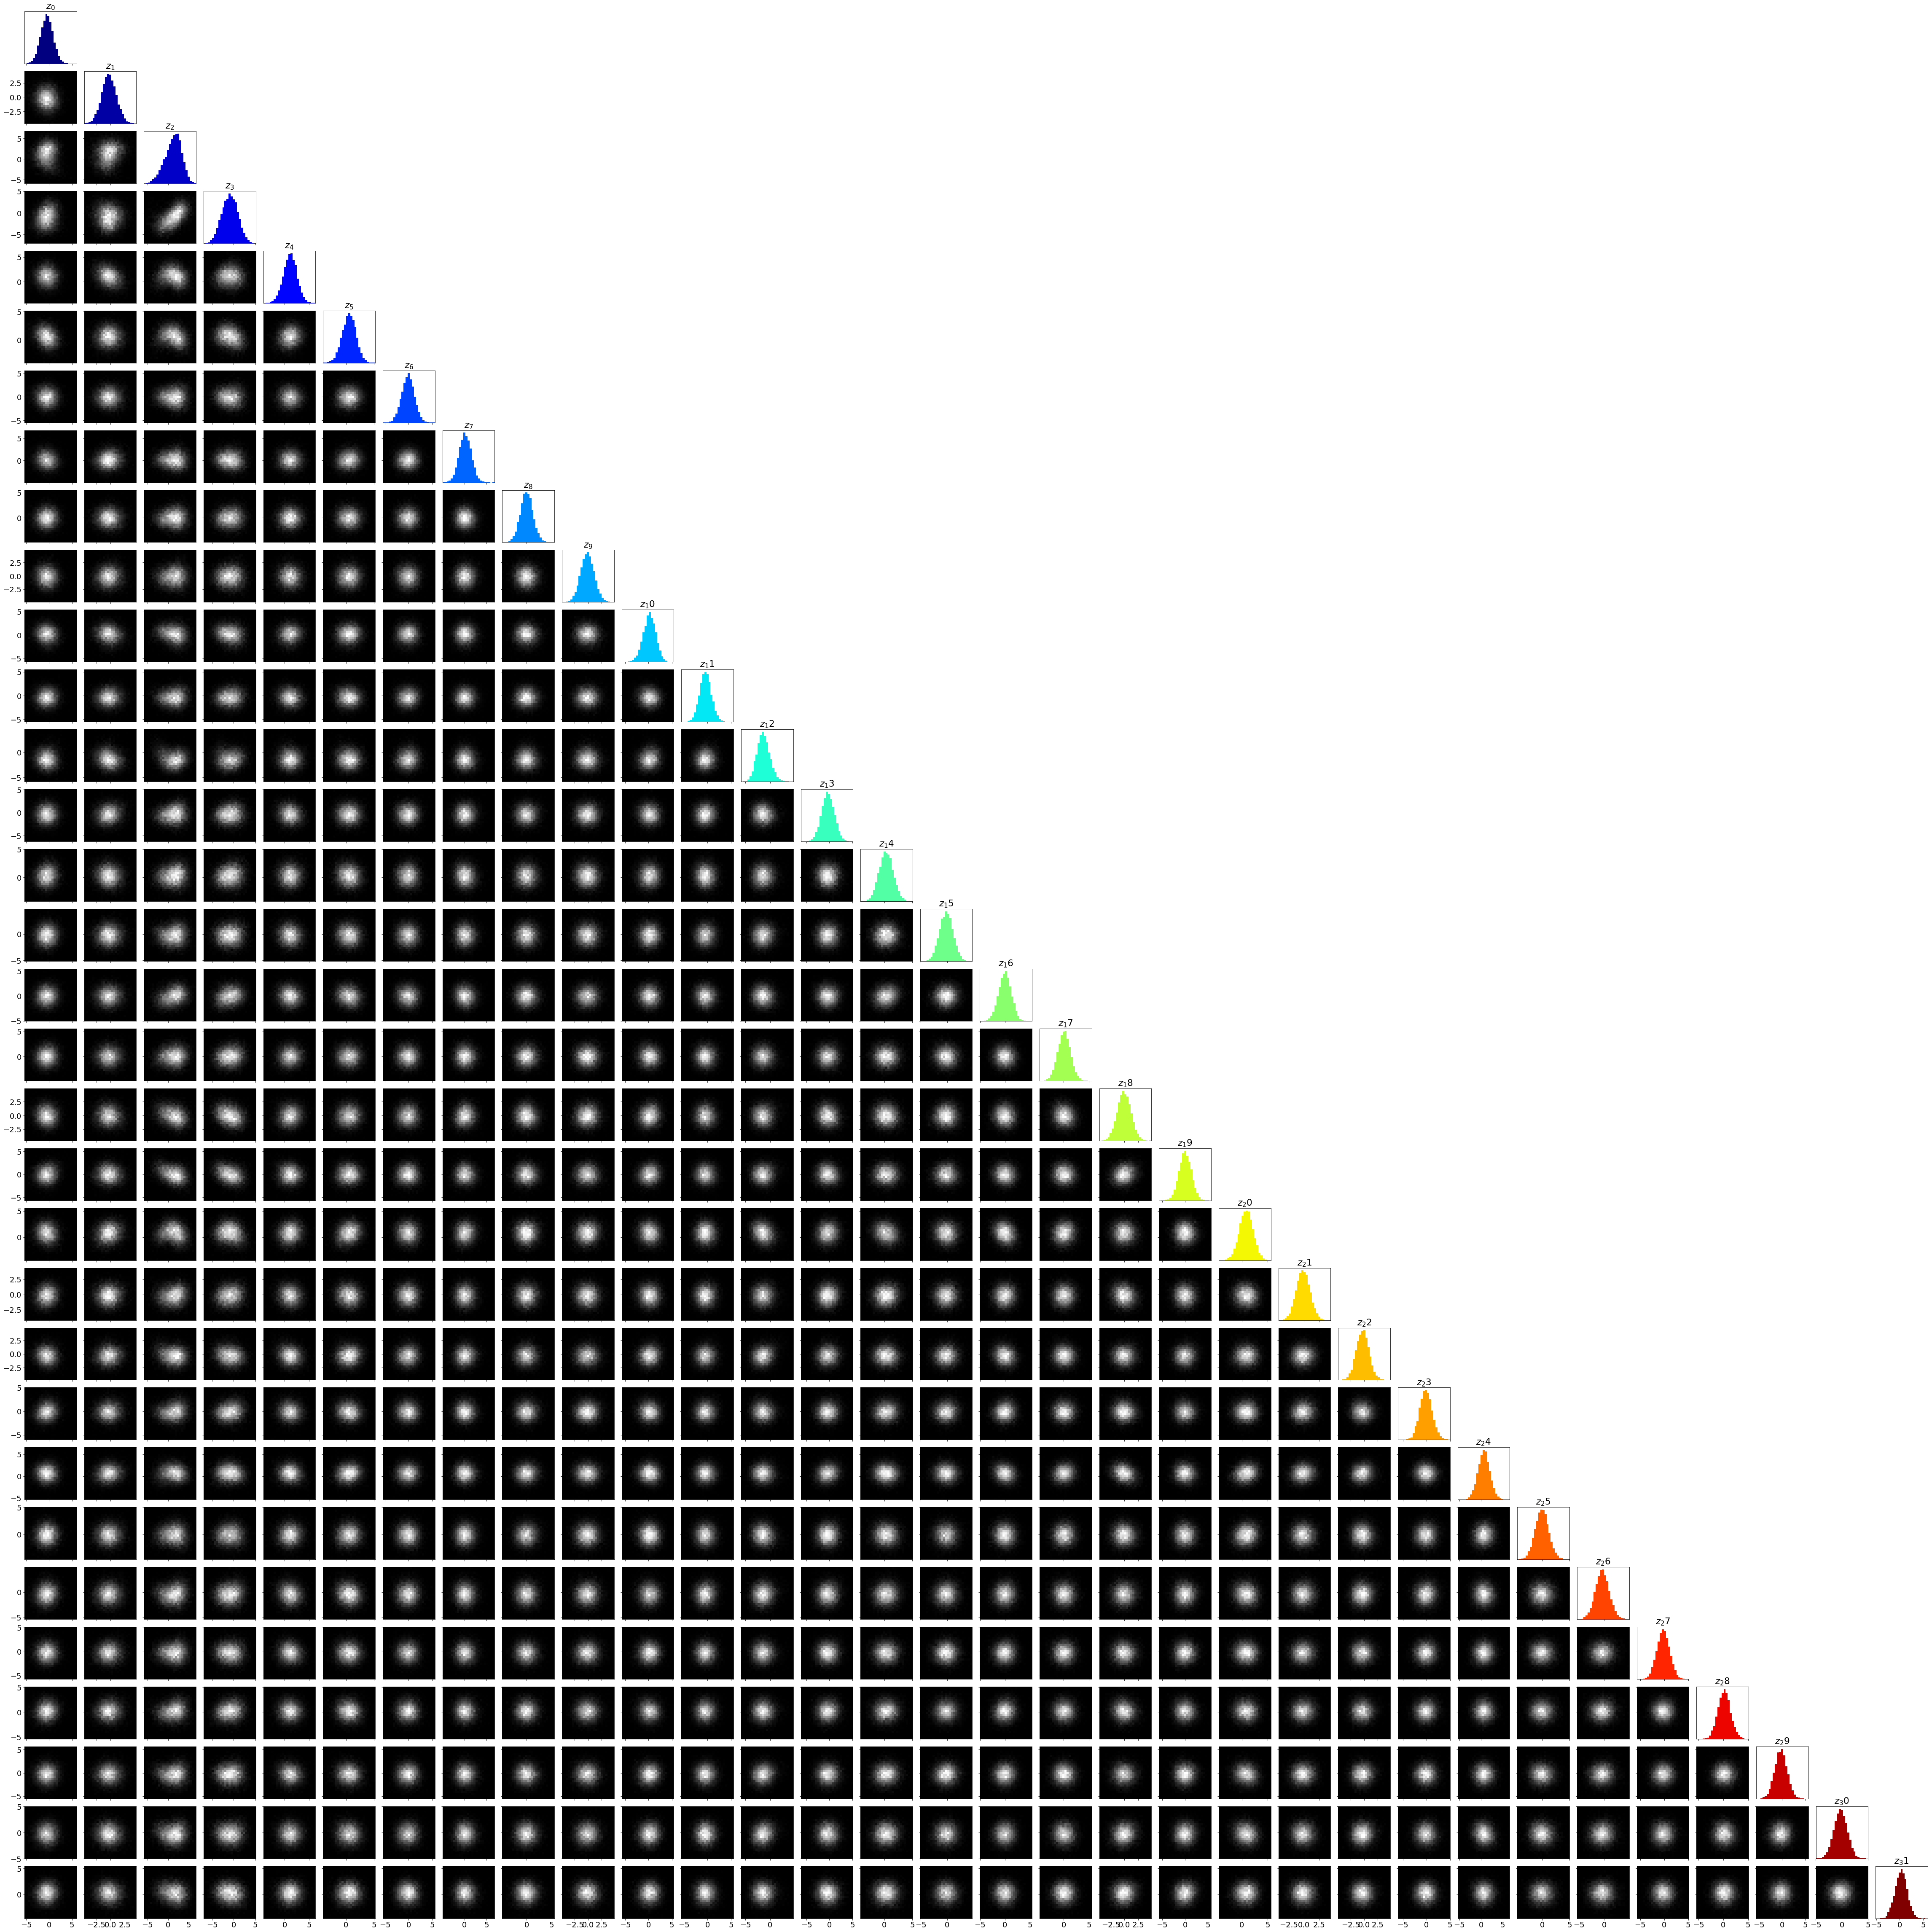

In [56]:
plot_corner_latent(z)

# LSST + Euclid

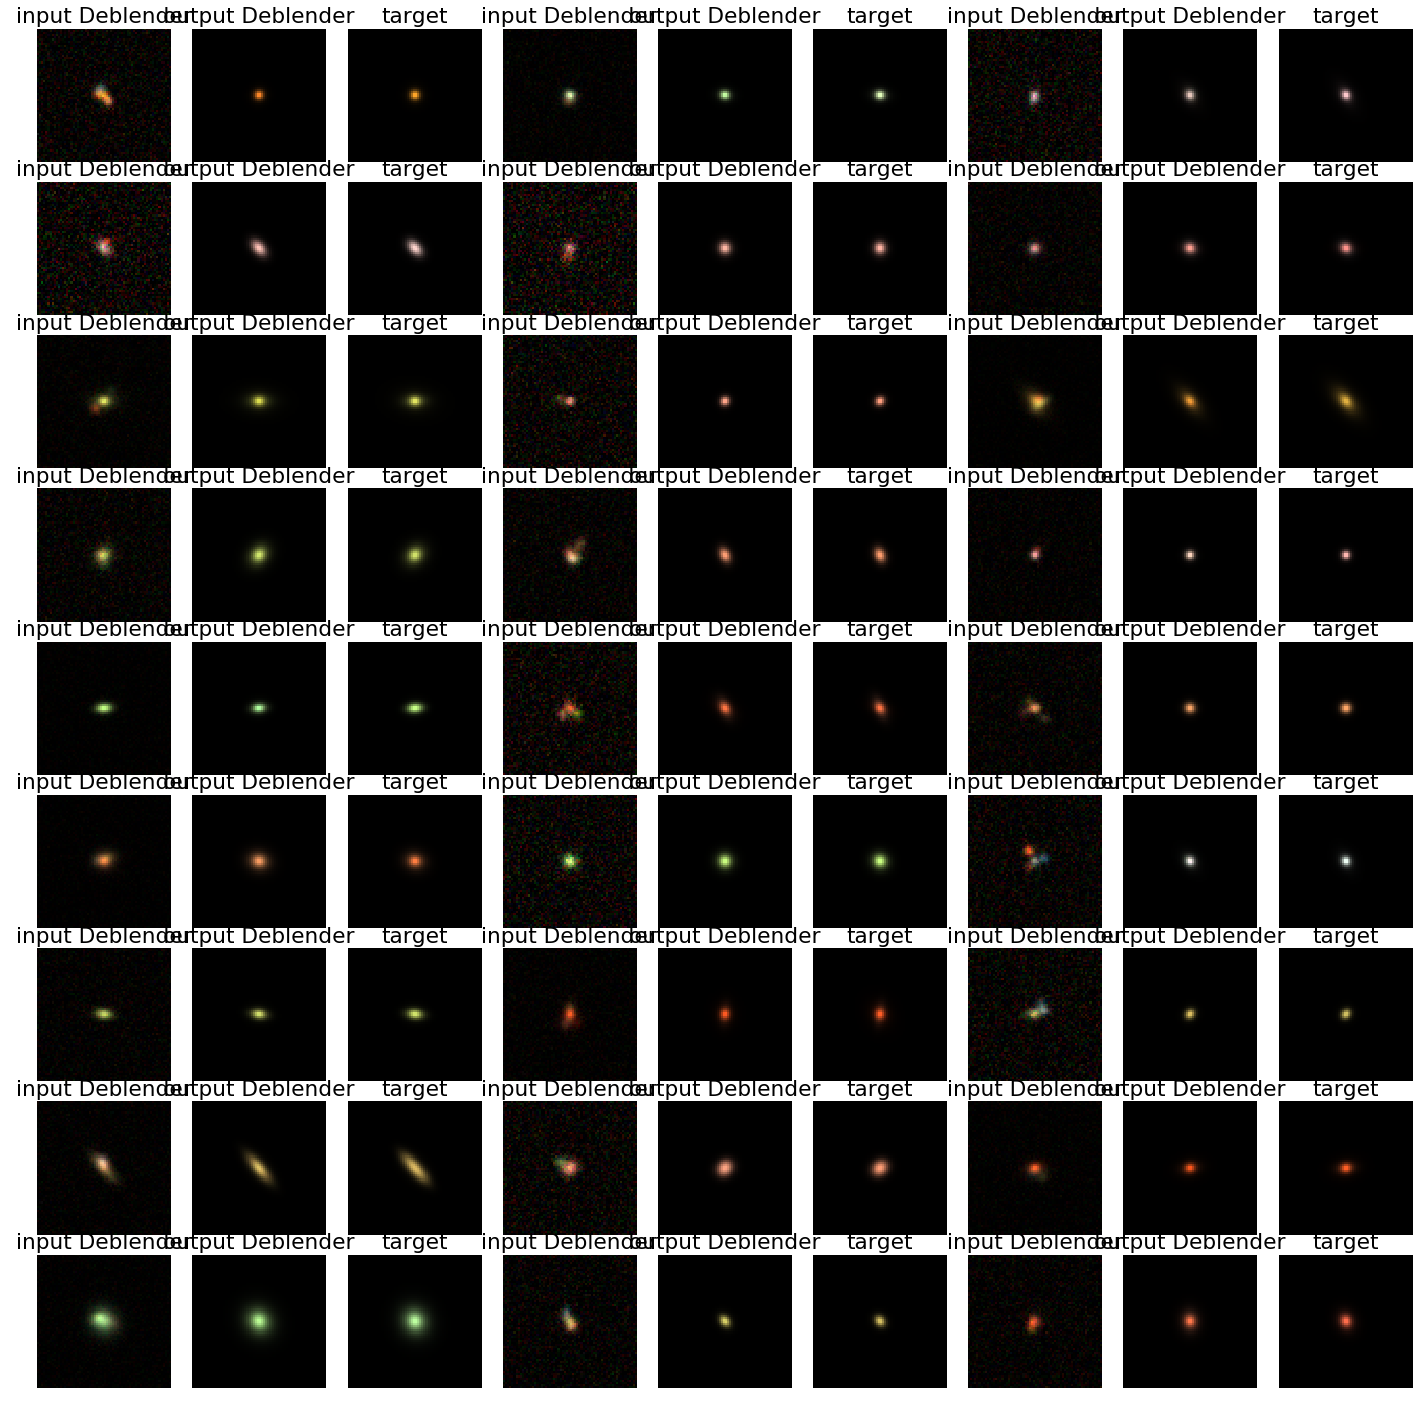

In [48]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst_euclid = batch_gen_lsst_euclid.__getitem__(2)
input_noisy = input_lsst_euclid[0]
input_noiseless = input_lsst_euclid[1]

output_deblender_lsst_euclid = deblender_lsst_euclid.predict(input_lsst_euclid[0], batch_size = 100)

output_deblender_lsst_euclid = denorm(output_deblender_lsst_euclid, bands_lsst_euclid, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst_euclid(output_deblender_lsst_euclid[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

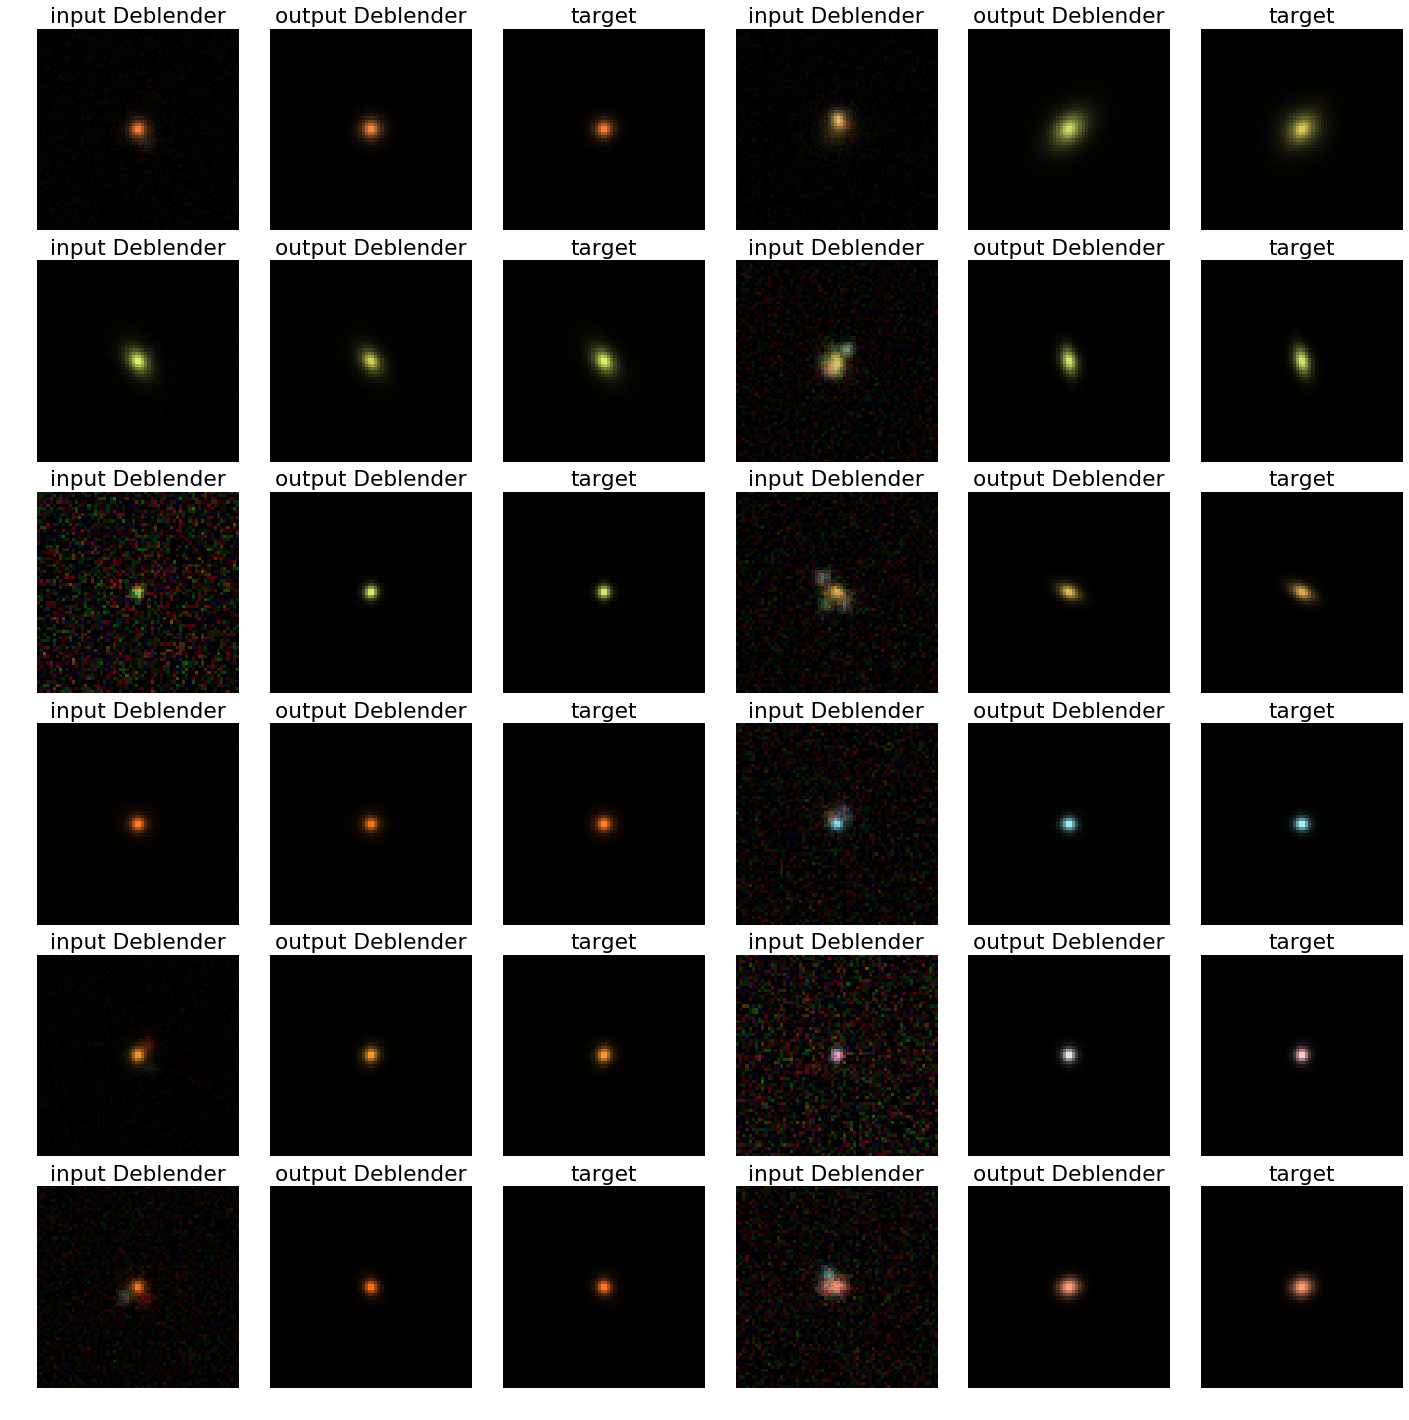

In [49]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst_euclid = batch_gen_lsst_euclid.__getitem__(2)
input_noisy = input_lsst_euclid[0]
input_noiseless = input_lsst_euclid[1]

output_deblender_lsst_euclid = deblender_lsst_euclid.predict(input_lsst_euclid[0], batch_size = 100)

output_deblender_lsst_euclid = denorm(output_deblender_lsst_euclid, bands_lsst_euclid, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst_euclid(output_deblender_lsst_euclid[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

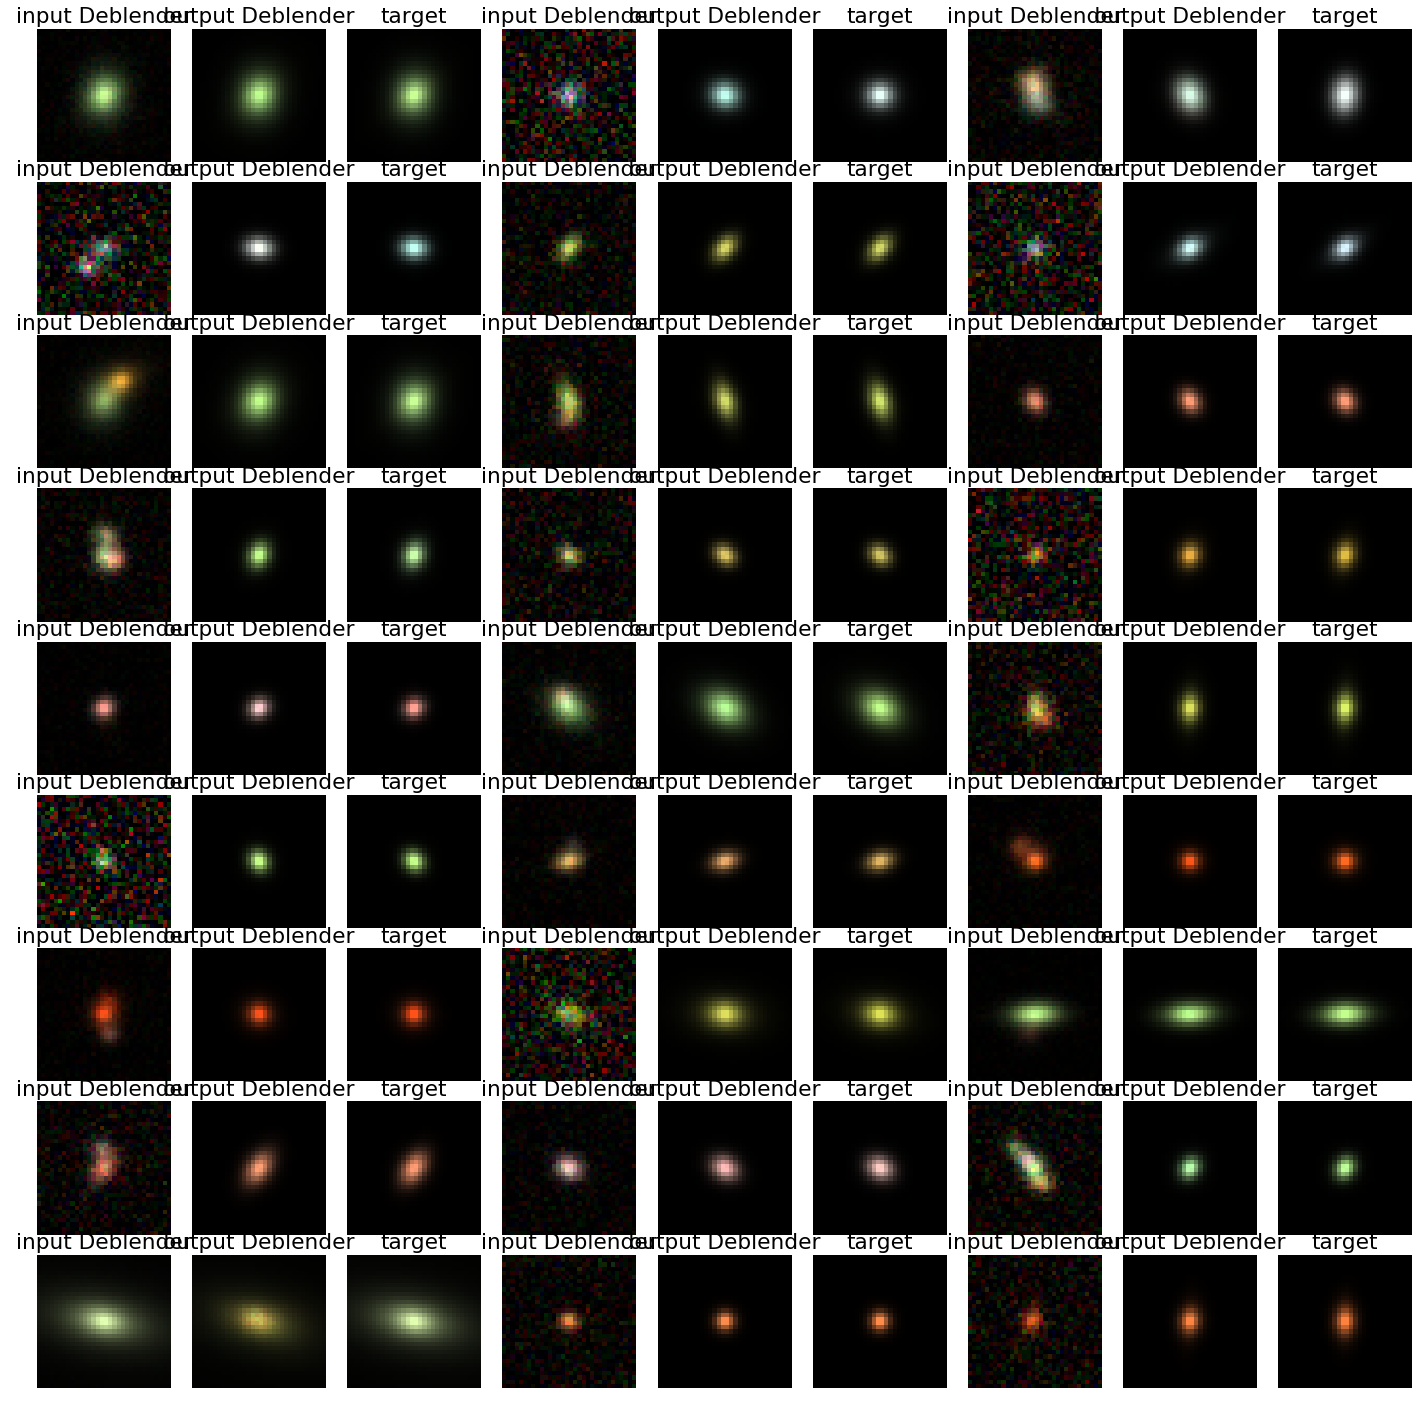

In [50]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst_euclid = batch_gen_lsst_euclid.__getitem__(2)
input_noisy = input_lsst_euclid[0]
input_noiseless = input_lsst_euclid[1]

output_deblender_lsst_euclid = deblender_lsst_euclid.predict(input_lsst_euclid[0], batch_size = 100)

output_deblender_lsst_euclid = denorm(output_deblender_lsst_euclid, bands_lsst_euclid, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]][16:48,16:48,:],int(stamp_size/2), axes[i,j])#input_vae
        plot_rgb_lsst_euclid(output_deblender_lsst_euclid[indices[i*N_plot+j]][16:48,16:48,:],int(stamp_size/2), axes[i,j+1])#output_vae
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]][16:48,16:48,:],int(stamp_size/2), axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

## Shape reproduction

In [ ]:
N = 100
batch_size = 100

ellipticities_lsst_euclid,e_beta_lsst_euclid, flux_in_lsst_euclid, flux_out_lsst_euclid, indices_lsst_euclid = deblender_processing(deblender_lsst_euclid, batch_gen_lsst_euclid,bands_lsst_euclid,6,stamp_size, N, batch_size)

In [58]:
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_deb_lsst_euclid.npy', [ellipticities_lsst_euclid,e_beta_lsst_euclid])
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_magnitudes_deb_lsst_euclid.npy', magnitudes_lsst_euclid)
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_deb_lsst_euclid.npy', [flux_in_lsst_euclid, flux_out_lsst_euclid, delta_r_lsst_euclid, delta_mag_lsst_euclid, max_blendedness_lsst_euclid, blend_total_lsst_euclid, SNR_lsst_euclid])

In [77]:
#ellipticities_lsst_euclid,e_beta_lsst_euclid = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_deb_lsst_euclid.npy')
#magnitudes_lsst_euclid = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_magnitudes_deb_lsst_euclid.npy')
#flux_in_lsst_euclid, flux_out_lsst_euclid, delta_r_lsst_euclid, delta_mag_lsst_euclid, max_blendedness_lsst_euclid, blend_total_lsst_euclid, SNR_lsst_euclid = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_deb_lsst_euclid.npy')


In [90]:
delta_e_lsst_euclid =  e_beta_lsst_euclid[:,1,0] - e_beta_lsst_euclid[:,0,0]

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


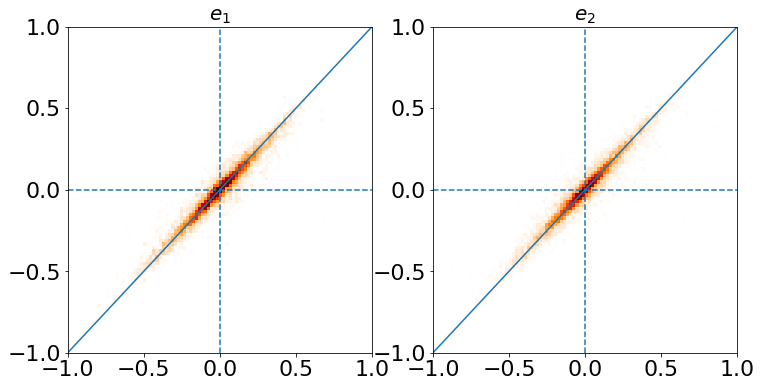

In [100]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst_euclid[:,0,i], ellipticities_lsst_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

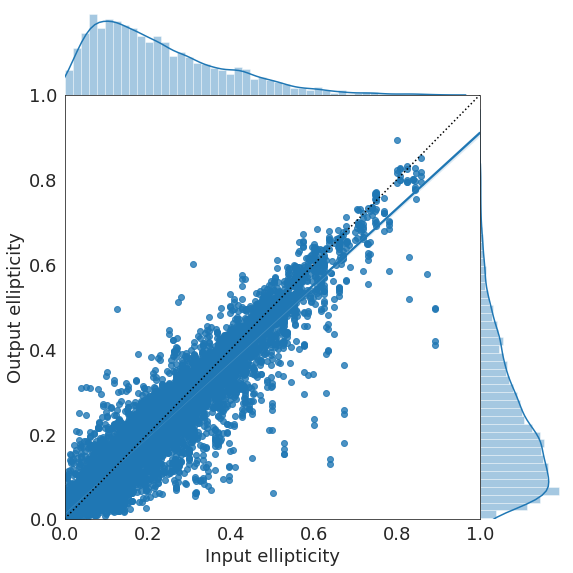

In [101]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


In [102]:
# Linear regression
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0])

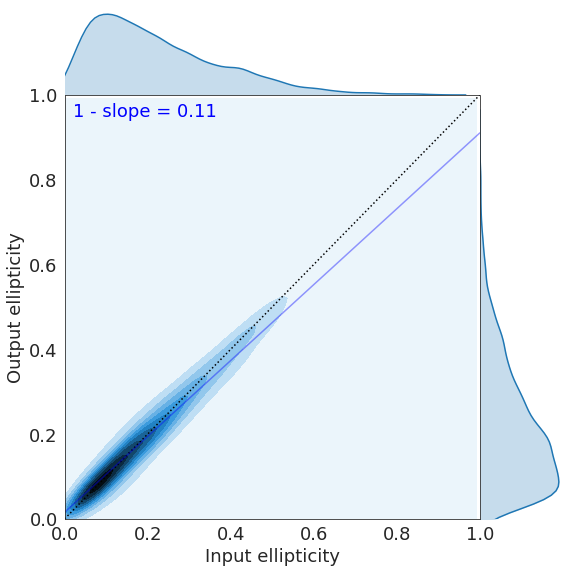

In [103]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
            
            g = sns.jointplot(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0,joint_kws={'shade_lowest':True}).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst_euclid*np.linspace(0, 1)+intercept_lsst_euclid, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst_euclid, 2)), color='b')

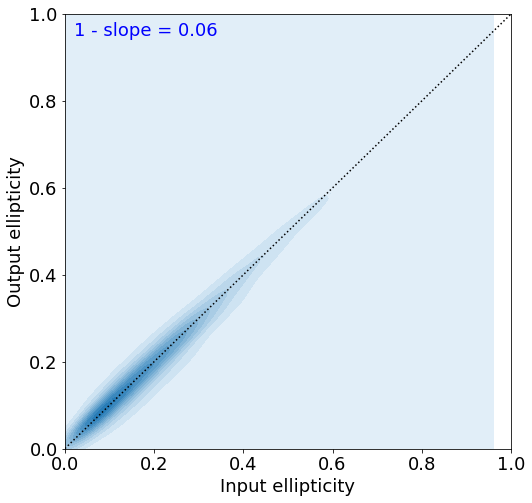

In [47]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,1, figsize=(8,8))

with sns.axes_style('white'):
            
            g = sns.kdeplot(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], kind='kde',height =8,
                              space=0,shade = True)
            #g.ax_joint.plot(np.linspace(0, 1),
            #                np.linspace(0, 1), ':k')
            #g.ax_joint.plot(np.linspace(0, 1),
            #                slope_lsst_euclid*np.linspace(0, 1)+intercept_lsst_euclid, color = 'b', alpha = 0.4)
            g.set_xlabel('Input ellipticity')
            g.set_ylabel('Output ellipticity')
            g.set_xlim(0, 1)
            g.set_ylim(0, 1)
            g.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')
            g.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst_euclid, 2)), color='b')

Text(-0.37, 800, 'median of histo = -0.002')

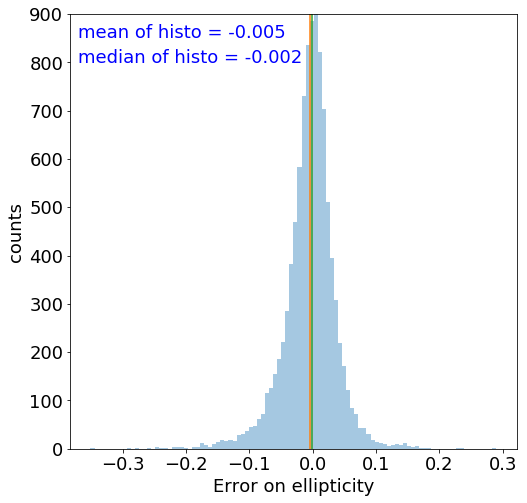

In [105]:
fig, axes = plt.subplots(1,1, figsize=(8,8))

a = sns.distplot(delta_e_lsst_euclid, bins = 100, hist = True, kde = False)
a.set_xlabel('Error on ellipticity')
a.set_ylabel('counts')
a.plot(np.ones((50,))*np.mean(delta_e_lsst_euclid),np.linspace(0, 1000))
a.plot(np.ones((50,))*np.median(delta_e_lsst_euclid),np.linspace(0, 1000))

a.set_ylim(0, 900)
a.text(-0.37, 850, 'mean of histo = '+str(round(np.mean(delta_e_lsst_euclid), 3)), color='b')
a.text(-0.37, 800, 'median of histo = '+str(round(np.median(delta_e_lsst_euclid), 3)), color='b')

## Flux reproduction

### In R band

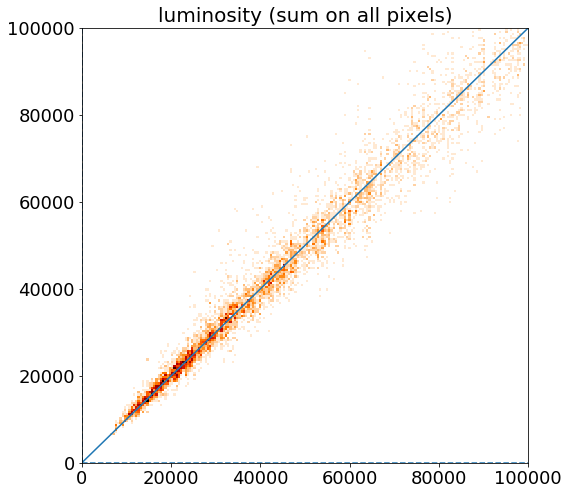

In [62]:
import matplotlib as mpl

max_lum = np.max(flux_in_lsst_euclid)

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(flux_in_lsst_euclid, flux_out_lsst_euclid, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

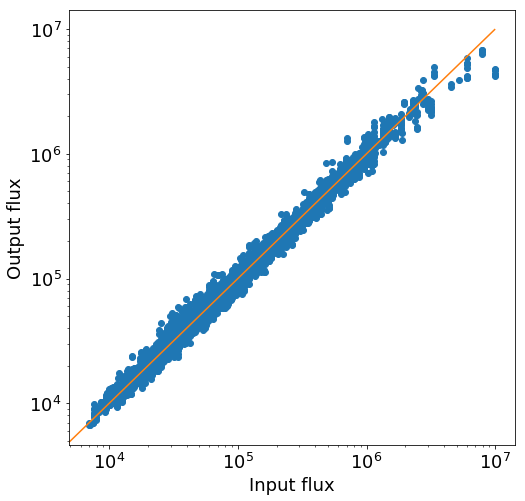

In [63]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(flux_in_lsst_euclid)
axes.plot(flux_in_lsst_euclid, flux_out_lsst_euclid,'o')

axes.plot([-emax,+emax],[-emax,+emax])
#axes.axhline(y=0, ls='--')
#axes.axvline(x=0, ls='--')
#axes.set_title('luminosity (sum on all pixels)')#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlabel('Input flux')
axes.set_ylabel('Output flux')
axes.set_xscale('log')
axes.set_yscale('log')

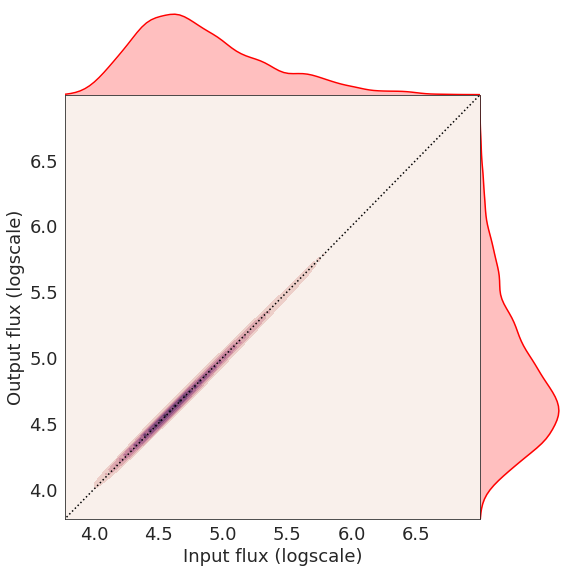

In [39]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst_euclid), np.log10(flux_out_lsst_euclid), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))], ylim=[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))), ':k')

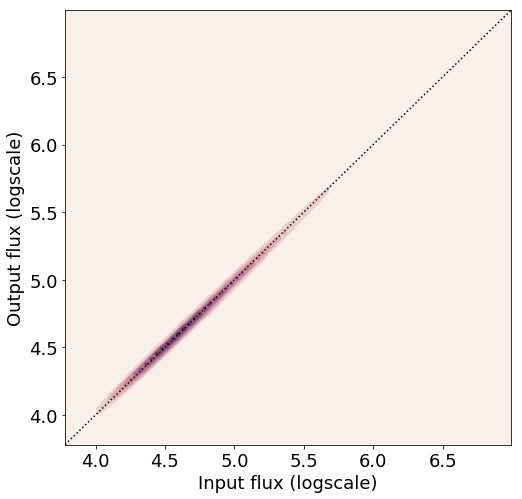

In [41]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,1, figsize=(8,8))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.kdeplot(np.log10(flux_in_lsst_euclid), np.log10(flux_out_lsst_euclid), kind='kde',height =8,
                              cmap=cmap,color = 'red', space=0, shade = True)
            g.set_xlabel('Input flux (logscale)')
            g.set_ylabel('Output flux (logscale)')
            g.set_xlim(np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid)))
            g.set_ylim(np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid)))
            g.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))), ':k')

### In all bands

In [65]:
N = 100

generator = batch_gen_lsst_euclid
deblender = deblender_lsst_euclid
bands = bands_lsst_euclid
im_size = stamp_size
batch_size = 100

In [66]:
N = 100

generator = batch_gen_lsst_euclid
deblender = deblender_lsst_euclid
bands = bands_lsst_euclid
im_size = stamp_size
batch_size = 100

flux_in_all_bands_lsst_euclid = np.empty([N,batch_size,10],dtype='float32')
flux_out_all_bands_lsst_euclid= np.empty([N,batch_size,10], dtype='float32')
for j in range(N):
    input_vae = generator.__getitem__(2)
    output_vae = deblender.predict(input_vae[0], batch_size = batch_size)
    output_vae = utils.denorm(output_vae, bands, channel_last = True)
    input_noiseless = utils.denorm(input_vae[1], bands, channel_last = True)

    for i in range (len(input_vae[0])):
        for k in range (len(input_noiseless[i][0,0])):
            # Measurement of fluxes
            mask = plot.createCircularMask(im_size,im_size,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,k].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,k].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            flux_in_all_bands_lsst_euclid[j,i,k] = np.sum(masked_img_in_simple)
            flux_out_all_bands_lsst_euclid[j,i,k] = np.sum(masked_img_out_simple)


In [32]:
#np.save('flux_lsst_euclid_deb.npy',flux_out_all_bands_lsst_euclid )

In [67]:
flux_in_all_bands_lsst_euclid.shape

(100, 100, 10)

In [68]:
flux_in_all_bands_lsst_euclid = np.concatenate(flux_in_all_bands_lsst_euclid, axis =0)
flux_out_all_bands_lsst_euclid = np.concatenate(flux_out_all_bands_lsst_euclid, axis =0)

In [69]:
print(flux_in_all_bands_lsst_euclid.shape, flux_out_all_bands_lsst_euclid.shape)

(10000, 10) (10000, 10)


In [70]:
flux_out_all_bands_lsst_euclid = np.concatenate(flux_out_all_bands_lsst_euclid, axis =0)

IndexError: too many indices for array

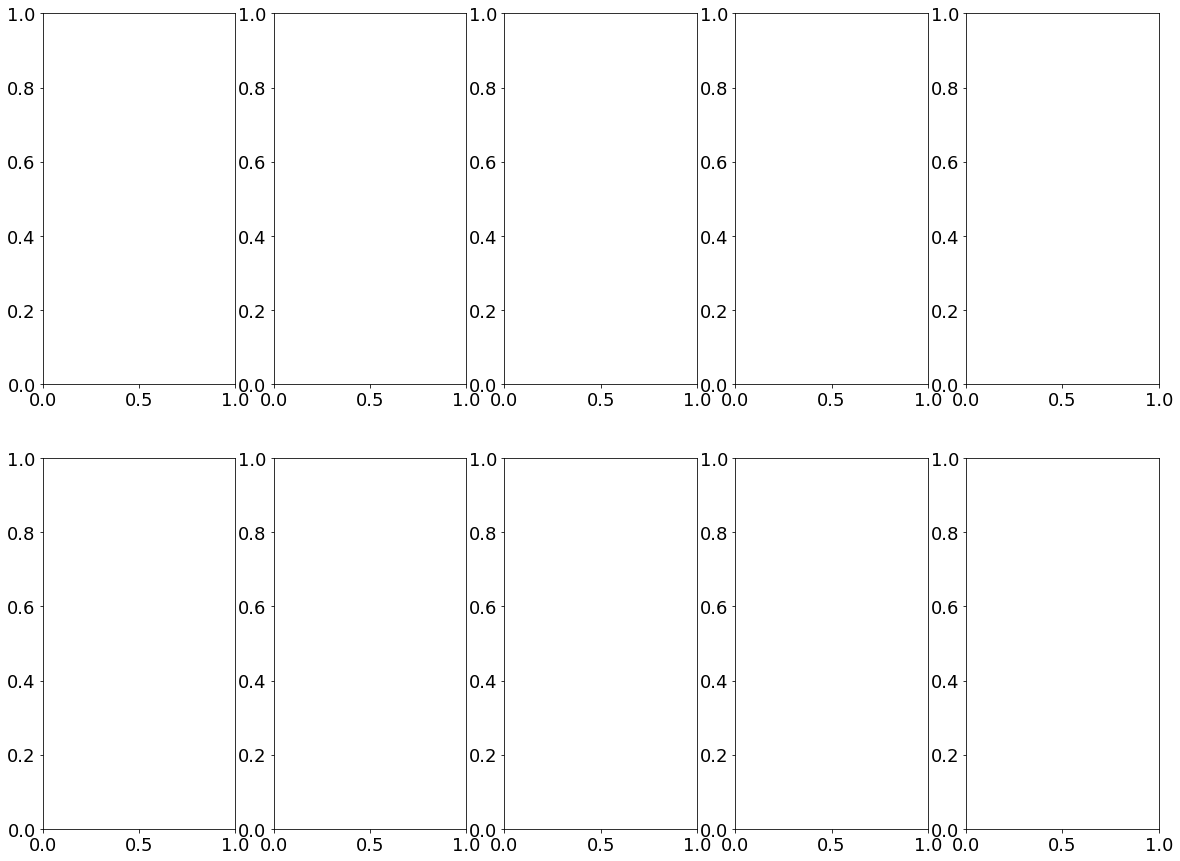

In [71]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

N = 5
fig, axes = plt.subplots(2,N, figsize=(20,15))

filter_names_all = 'HJHVugrizy'

j = 0
i = 0

for filter_name in filter_names_all:
    ax = axes[j,i]
    ax.plot(flux_in_all_bands_lsst_euclid[:,i+j*N], flux_out_all_bands_lsst_euclid[:,i+j*N],'o')
    emax = np.max(flux_in_all_bands_lsst_euclid[:,i+j*N])
    ax.plot([-emax,+emax],[-emax,+emax])
    ax.spines['bottom']
    ax.spines['right']
    ax.spines['left']
    ax.spines['top']
    ax.xaxis.label
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    if i == 0 or i == 5:
        ax.set_ylabel('Output flux')
    ax.set_xlabel('Input {0} bandpass flux'.format(filter_name))
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 4:
        j = 1
        i = 0
    else:
        i+=1

# Delta e as function of parameters

Histogram of total Euclid blendedness for the whole sample

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


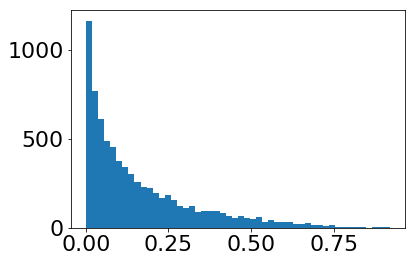

In [25]:
_ = plt.hist(df['blendedness_total_euclid'], bins = 50)

Histogram of SNR for whole sample

Text(0.5, 0, 'SNR (logscale)')

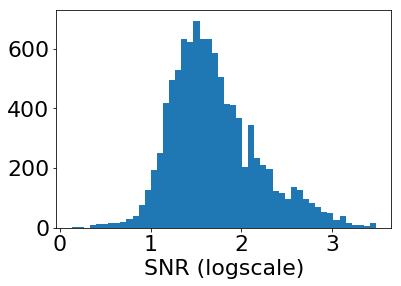

In [30]:
_ = plt.hist(np.log10(df['SNR']), bins = 50)
plt.xlabel('SNR (logscale)')

## As function of SNR

### Error on ellipticity

In [96]:
SNR_lsst = df['SNR'][indices_lsst]
SNR_lsst_euclid = df['SNR'][indices_lsst_euclid]

In [112]:
reload(plot)

<module 'tools_for_VAE.plot' from '../../scripts/tools_for_VAE/tools_for_VAE/plot.py'>

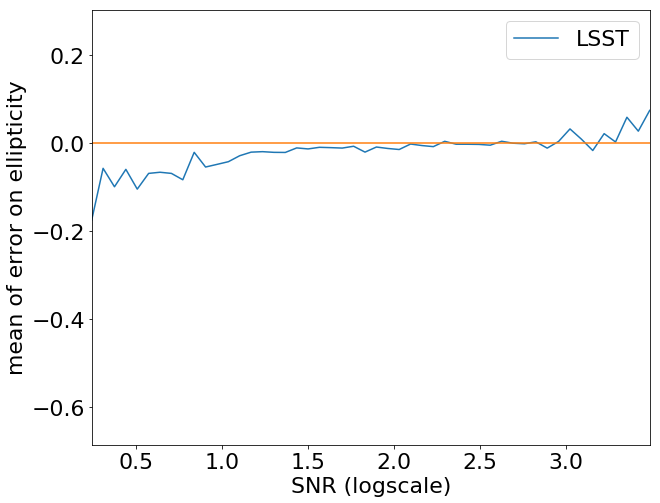

In [113]:
plot.v_as_function_of_p(v = [delta_e_lsst],
                        p = [np.log10(SNR_lsst)], 
                        v_labels = ['LSST'],
                        x_label = 'SNR (logscale)', 
                        y_label = 'mean of error on ellipticity')

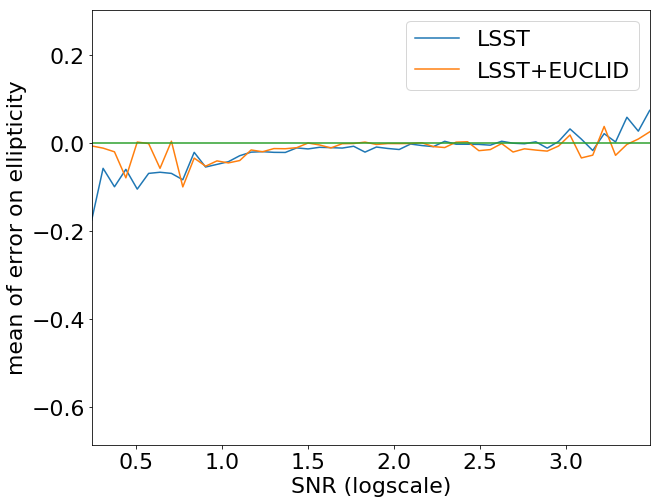

In [114]:
plot.v_as_function_of_p(v = [delta_e_lsst, delta_e_lsst_euclid],
                        p = [np.log10(SNR_lsst), np.log10(SNR_lsst_euclid)], 
                        v_labels = ['LSST', 'LSST+EUCLID'], 
                        x_label = 'SNR (logscale)', 
                        y_label = 'mean of error on ellipticity')

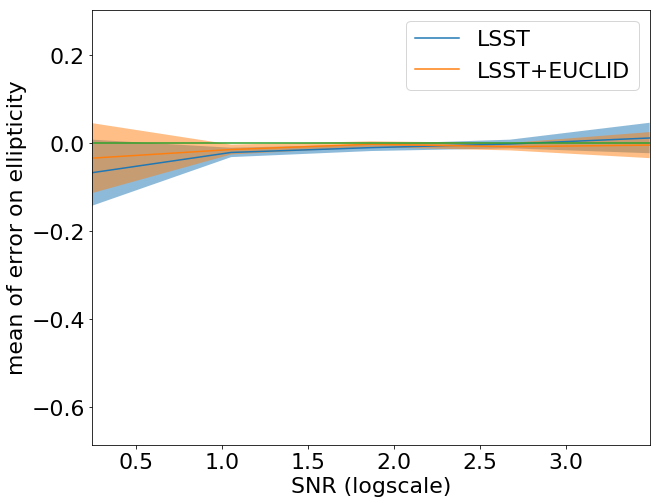

In [115]:
plot.v_as_function_of_p(v = [delta_e_lsst, delta_e_lsst_euclid],
                        p = [np.log10(SNR_lsst), np.log10(SNR_lsst_euclid)], 
                        v_labels = ['LSST', 'LSST+EUCLID'], 
                        x_label = 'SNR (logscale)', 
                        y_label = 'mean of error on ellipticity',
                        variance = True,
                        bins = 5)

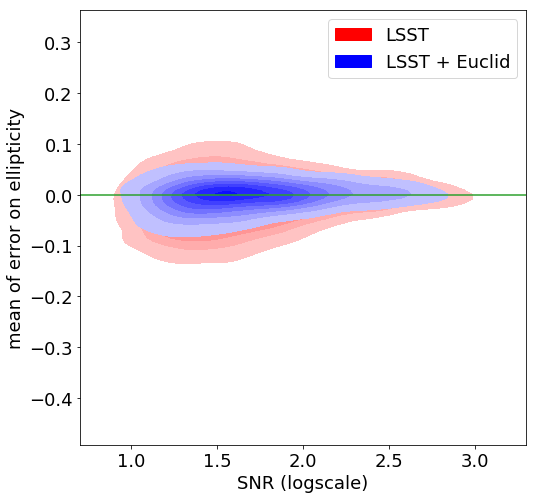

In [129]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1, figsize=(8,8))

with sns.axes_style('white'):
            g = sns.kdeplot(np.log10(SNR_lsst),delta_e_lsst, shade = True, color = 'r', shade_lowest=False, label='LSST')
            g = sns.kdeplot(np.log10(SNR_lsst_euclid),delta_e_lsst_euclid, shade = True, color = 'b',shade_lowest=False, label='LSST + Euclid')
g.set_ylabel('mean of error on ellipticity')
g.set_xlabel('SNR (logscale)')
g.plot(np.arange(0,10), np.zeros((10)))
g.set_xlim(0.7,3.3)
g.legend()

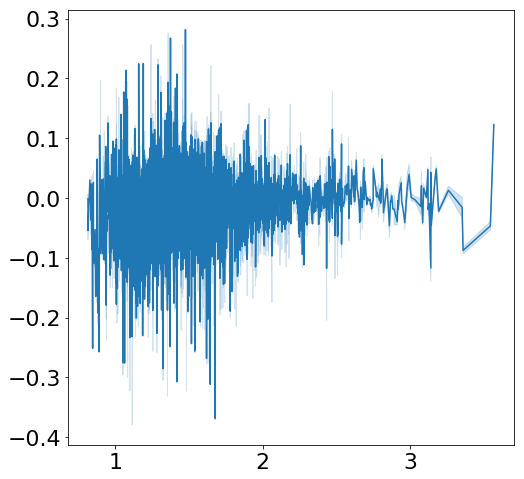

In [135]:
fig, axes = plt.subplots(1, figsize=(8,8))

test = sns.lineplot(np.log10(SNR_lsst),delta_e_lsst)#, bins = 10)


### Error on flux

In [110]:
delta_flux_abs_lsst = (flux_out_lsst-flux_in_lsst)/flux_in_lsst
delta_flux_abs_lsst_euclid = (flux_out_lsst_euclid-flux_in_lsst_euclid)/flux_in_lsst_euclid

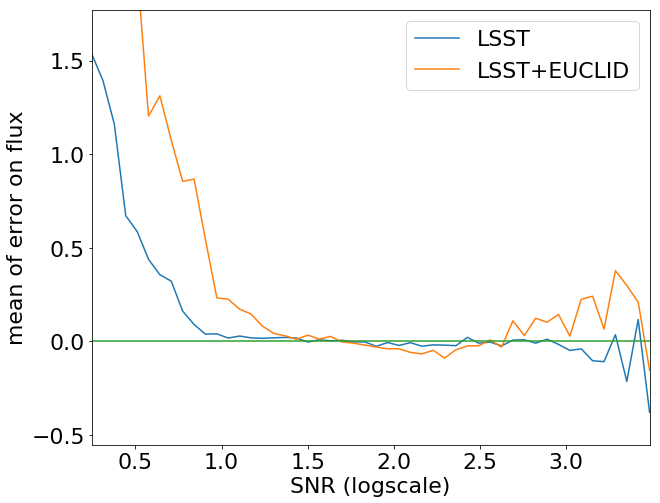

In [117]:
plot.v_as_function_of_p(v = [delta_flux_abs_lsst, delta_flux_abs_lsst_euclid],
                        p = [np.log10(SNR_lsst), np.log10(SNR_lsst_euclid)], 
                        v_labels = ['LSST', 'LSST+EUCLID'], 
                        x_label = 'SNR (logscale)', 
                        y_label = 'mean of error on flux',
                        variance = False,
                        bins = 50)

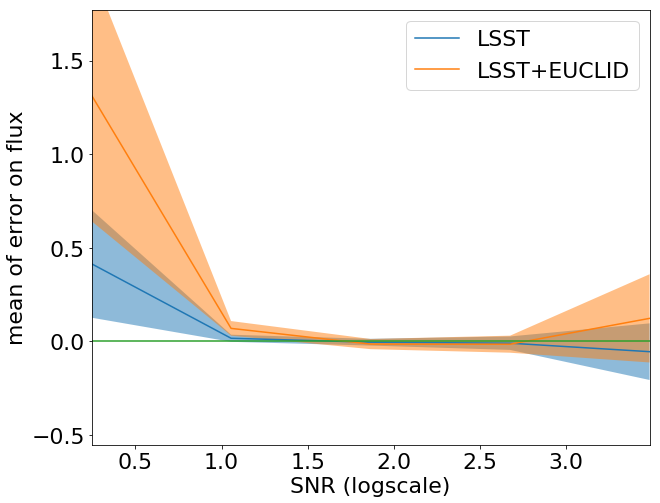

In [116]:
plot.v_as_function_of_p(v = [delta_flux_abs_lsst, delta_flux_abs_lsst_euclid],
                        p = [np.log10(SNR_lsst), np.log10(SNR_lsst_euclid)], 
                        v_labels = ['LSST', 'LSST+EUCLID'], 
                        x_label = 'SNR (logscale)', 
                        y_label = 'mean of error on flux',
                        variance = True,
                        bins = 5)

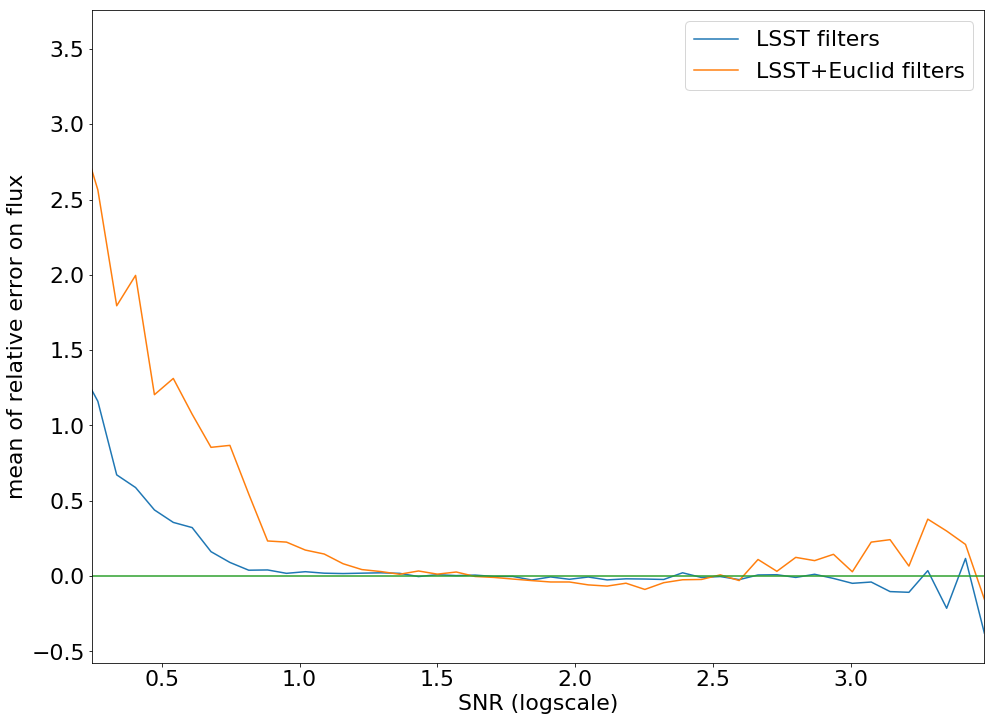

In [118]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(np.log10(np.min(SNR_lsst)), np.log10(np.max(SNR_lsst)))
#plt.ylim(-0.15, 0.15)

plt.xlabel('SNR (logscale)')
plt.ylabel('mean of relative error on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)

## As a function of blend rate

### As a function of blend rate with closest

#### Error on ellipticity

In [ ]:
max_blendedness_lsst = df['blendedness_closest_lsst '][indices_lsst]
max_blendedness_lsst_euclid = df['blendedness_closest_lsst'][indices_lsst_euclid]

In [75]:
print("Mean of delta e for LSST filters: "+str(np.mean(delta_e_lsst)))
print("Mean of delta e for LSST + Euclid filters: "+str(np.mean(delta_e_lsst_euclid)))

Mean of delta e for LSST filters: -0.012477037569517126
Mean of delta e for LSST + Euclid filters: -0.004153074898696651


In [76]:
image_1 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_0.2_max_blend.npy')
image_2 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_0.52_max_blend.npy')
image_3 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_0.73_max_blend.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_0.2_max_blend.npy'

In [65]:
image_1[1][0]

0.20656037330627441

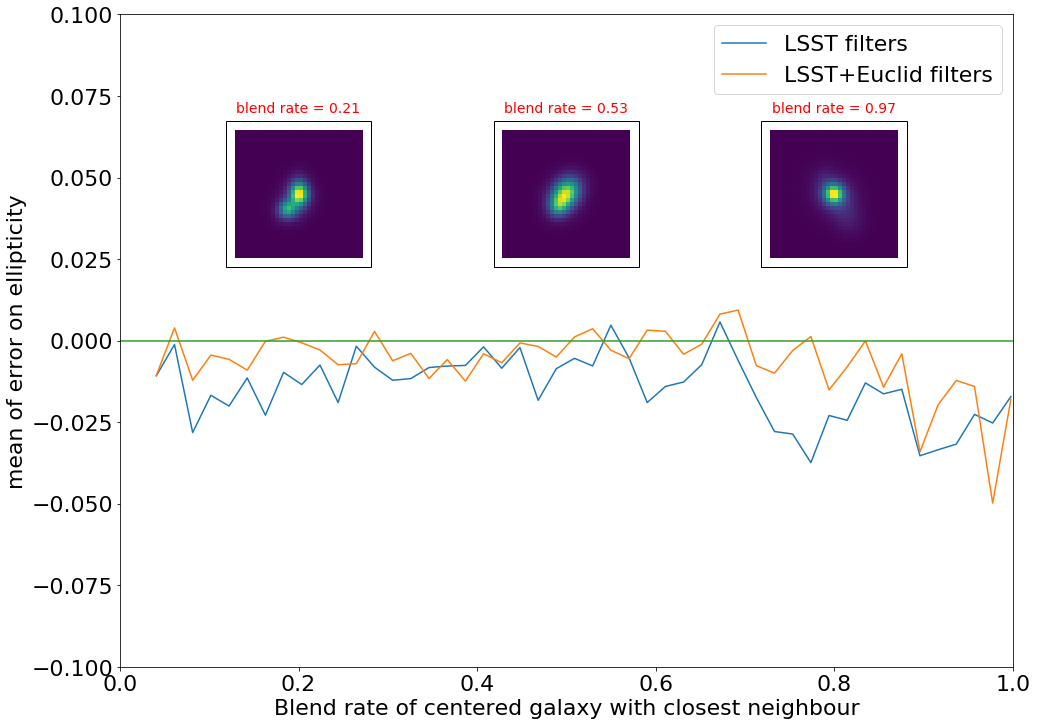

In [66]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(max_blendedness_lsst,delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(max_blendedness_lsst_euclid,delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(max_blendedness_lsst_euclid), np.max(max_blendedness_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

imagebox = OffsetImage(image_1[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.2, 0.045))
axes.add_artist(ab)
axes.text(0.13, 0.07, 'blend rate = '+str(np.round(image_1[1][0], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_2[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.5, 0.045))
axes.add_artist(ab)
axes.text(0.43, 0.07, 'blend rate = '+str(np.round(image_2[1][0], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_3[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.8, 0.045))
axes.add_artist(ab)
axes.text(0.73, 0.07, 'blend rate = '+str(np.round(image_3[1][0], 2)), fontsize =14, color='r')

plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.1, 0.1)

plt.xlabel('Blend rate of centered galaxy with closest neighbour')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


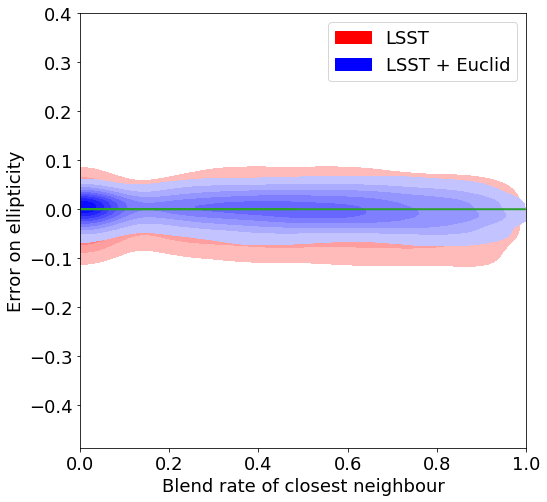

In [55]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1, figsize=(8,8))

with sns.axes_style('white'):
            g = sns.kdeplot(max_blendedness_lsst,delta_e_lsst, shade = True, color = 'r', shade_lowest=False, label='LSST')
            g = sns.kdeplot(max_blendedness_lsst_euclid,delta_e_lsst_euclid, shade = True, color = 'b',shade_lowest=False, label='LSST + Euclid')
g.set_ylabel('Error on ellipticity')
g.set_xlabel('Blend rate of closest neighbour')
g.plot(max_blendedness_lsst, np.zeros((10000)))
g.set_xlim(0,1)
g.legend()

### As a function of total blend rate

#### Error on ellipticity

In [ ]:
blend_total_lsst = df['blendedness_total_lsst '][indices_lsst]
blend_total_lsst_euclid = df['blendedness_total_lsst'][indices_lsst_euclid]

In [67]:
image_total_1 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_total_0.23.npy')
image_total_2 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_total_0.53.npy')
image_total_3 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_total_0.82.npy')

In [68]:
image_total_3[1]

0.8280306458473206

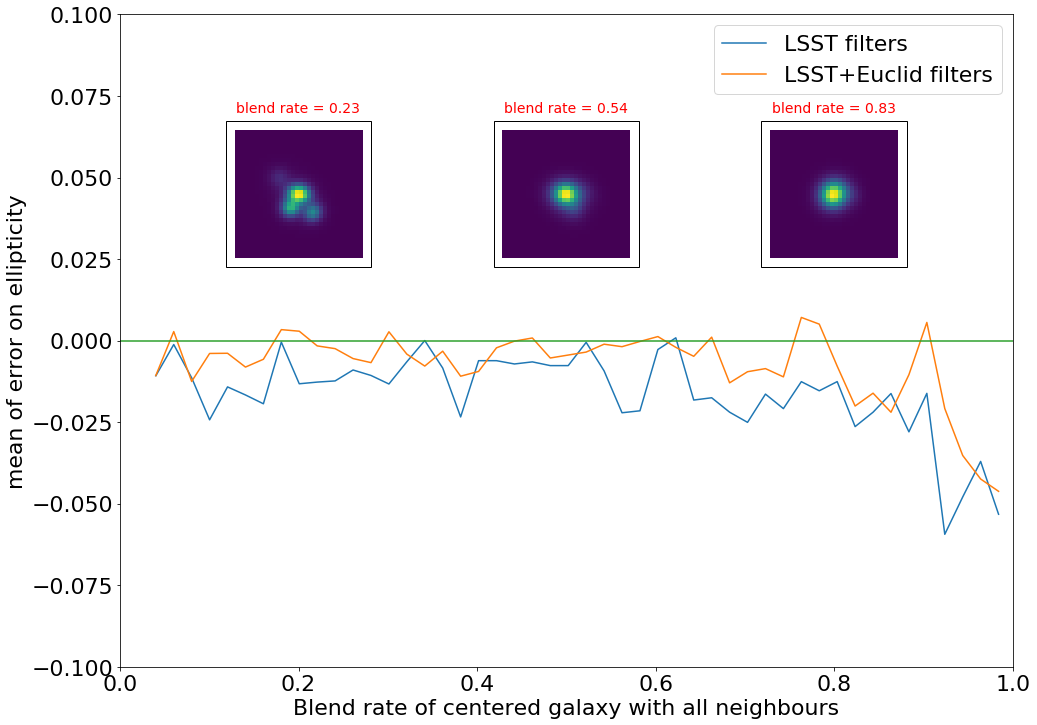

In [69]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(blend_total_lsst,delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(blend_total_lsst_euclid,delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(blend_total_lsst_euclid), np.max(blend_total_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

imagebox = OffsetImage(image_total_1[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.2, 0.045))
axes.add_artist(ab)
axes.text(0.13, 0.07, 'blend rate = '+str(np.round(image_total_1[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_2[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.5, 0.045))
axes.add_artist(ab)
axes.text(0.43, 0.07, 'blend rate = '+str(np.round(image_total_2[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_3[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.8, 0.045))
axes.add_artist(ab)
axes.text(0.73, 0.07, 'blend rate = '+str(np.round(image_total_3[1], 2)), fontsize =14, color='r')

plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.1, 0.1)

plt.xlabel('Blend rate of centered galaxy with all neighbours')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


#### Error on flux

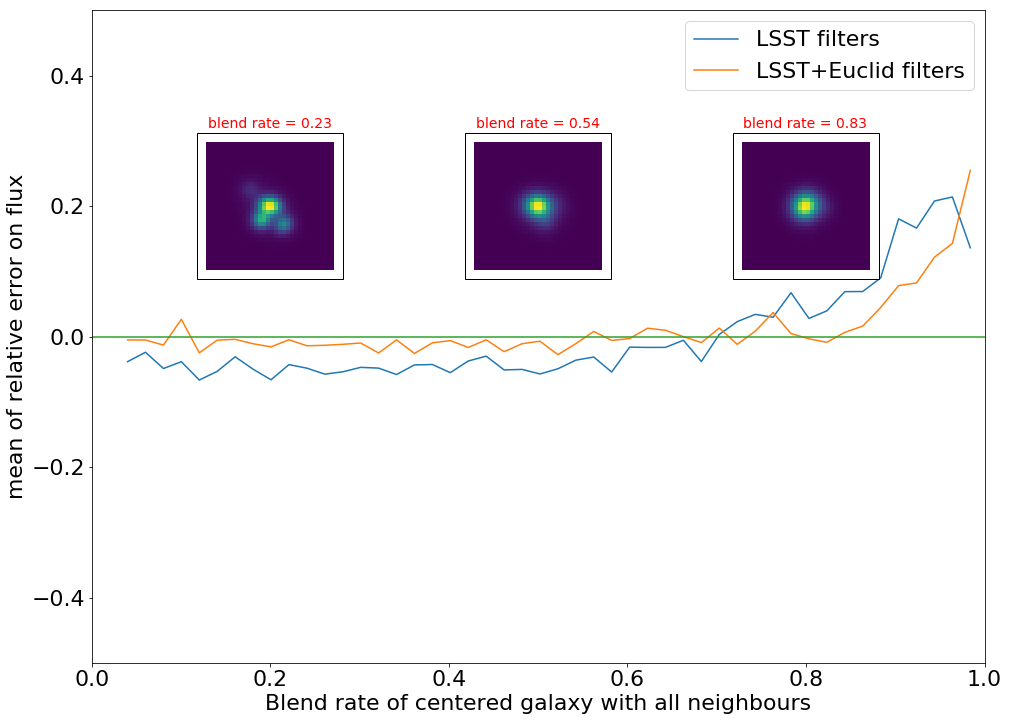

In [70]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(blend_total_lsst,delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(blend_total_lsst_euclid,delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(blend_total_lsst_euclid), np.max(blend_total_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

imagebox = OffsetImage(image_total_1[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.2, 0.2))
axes.add_artist(ab)
axes.text(0.13, 0.32, 'blend rate = '+str(np.round(image_total_1[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_2[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.5, 0.2))
axes.add_artist(ab)
axes.text(0.43, 0.32, 'blend rate = '+str(np.round(image_total_2[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_3[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.8, 0.2))
axes.add_artist(ab)
axes.text(0.73, 0.32, 'blend rate = '+str(np.round(image_total_3[1], 2)), fontsize =14, color='r')

plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.5, 0.5)

plt.xlabel('Blend rate of centered galaxy with all neighbours')
plt.ylabel('mean of relative error on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


## As a function of delta magnitude

### Error on ellipticity

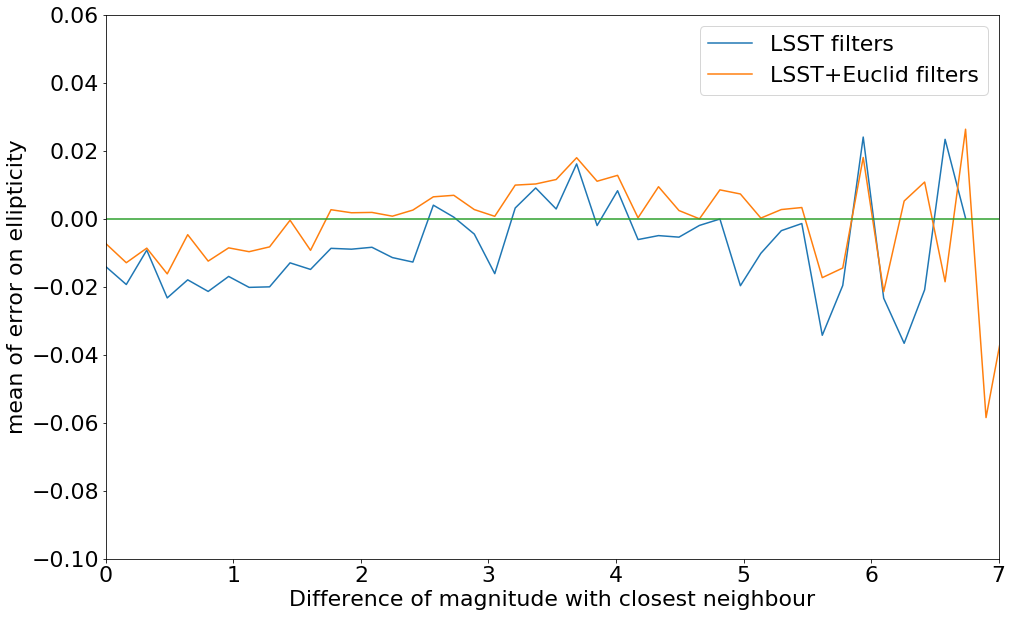

In [71]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_lsst, var_SNR_lsst = mean_var(delta_mag_lsst,delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(delta_mag_lsst_euclid,delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(delta_mag_lsst_euclid), np.max(delta_mag_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 7)#np.max(delta_mag_lsst))
plt.ylim(-0.10,0.06)

plt.xlabel('Difference of magnitude with closest neighbour')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


### Error on flux

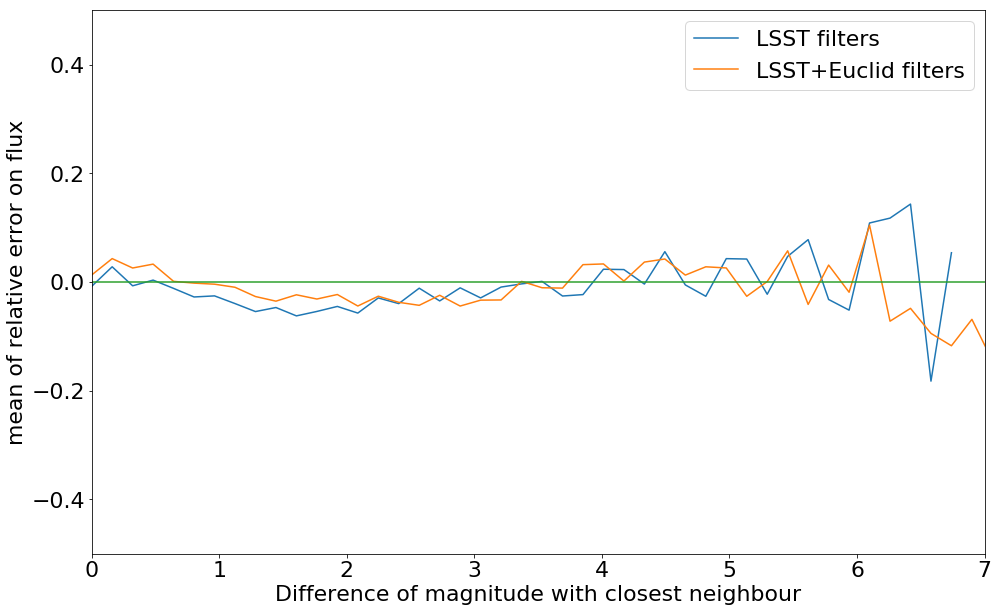

In [72]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_lsst, var_SNR_lsst = mean_var(delta_mag_lsst,delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(delta_mag_lsst_euclid,delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(delta_mag_lsst_euclid), np.max(delta_mag_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 7)#np.max(delta_mag_lsst))
plt.ylim(-0.5,0.5)

plt.xlabel('Difference of magnitude with closest neighbour')
plt.ylabel('mean of relative error on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


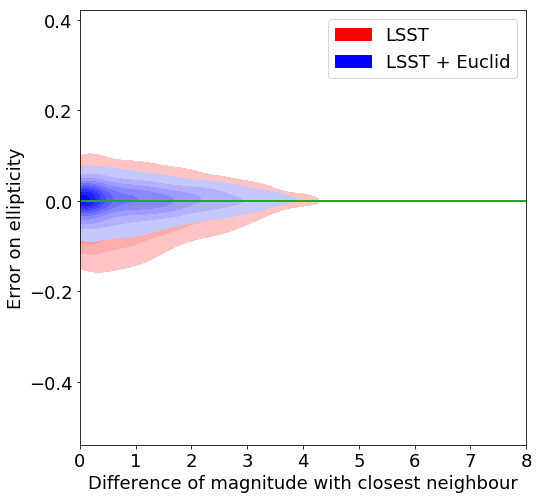

In [80]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1, figsize=(8,8))

with sns.axes_style('white'):
            g = sns.kdeplot(delta_mag_lsst,delta_e_lsst, shade = True, color = 'r', shade_lowest=False, label = 'LSST')
            g = sns.kdeplot(delta_mag_lsst_euclid,delta_e_lsst_euclid, shade = True, color = 'b',shade_lowest=False, label = 'LSST + Euclid')
g.set_ylabel('Error on ellipticity')
g.set_xlabel('Difference of magnitude with closest neighbour')
g.plot(delta_mag_lsst, np.zeros((10000)))
g.set_xlim(0,8)
g.legend()

# N sampling for the same galaxy on few blended images

In [31]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [32]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
0


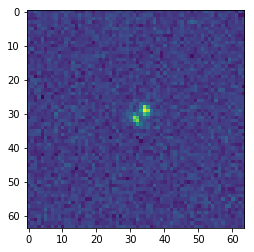

In [33]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
input_noisy = []
output_deblender = []
output_deblender_lsst_euclid = []
blend_rate = []
nb_of_gal = []
err_count = 0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    input_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = deblender_lsst.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_lsst, channel_last = True)
        
        output_vae_list_lsst_euclid = deblender_lsst_euclid.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
        output_vae_list_lsst_euclid = denorm (output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)
        
        if j == (nb_of_samplings-1) :  
            input_noisy.append(denorm(list_galsim_simple[0], bands_lsst_euclid, channel_last = True))
            output_deblender.append(output_vae_list_lsst)
            output_deblender_lsst_euclid.append(output_vae_list_lsst_euclid)
            blend_rate.append(list_galsim_simple[7][0])
            nb_of_gal.append(len(list_galsim_simple[5]))

        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst[t,:,:,2].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)

            img_out_simple_euclid = galsim.Image(output_vae_list_lsst_euclid[t][:,:,6])
            res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e1
            res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e2
            res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst_euclid[t,:,:,6].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)

    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

In [34]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = input_noiseless[k][0][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple)

    print(res_in_e1[k], res_in_e2[k])

0.0015546844 0.0059353914
0.24678348 0.26398543
-0.22094715 0.34989557


[]

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


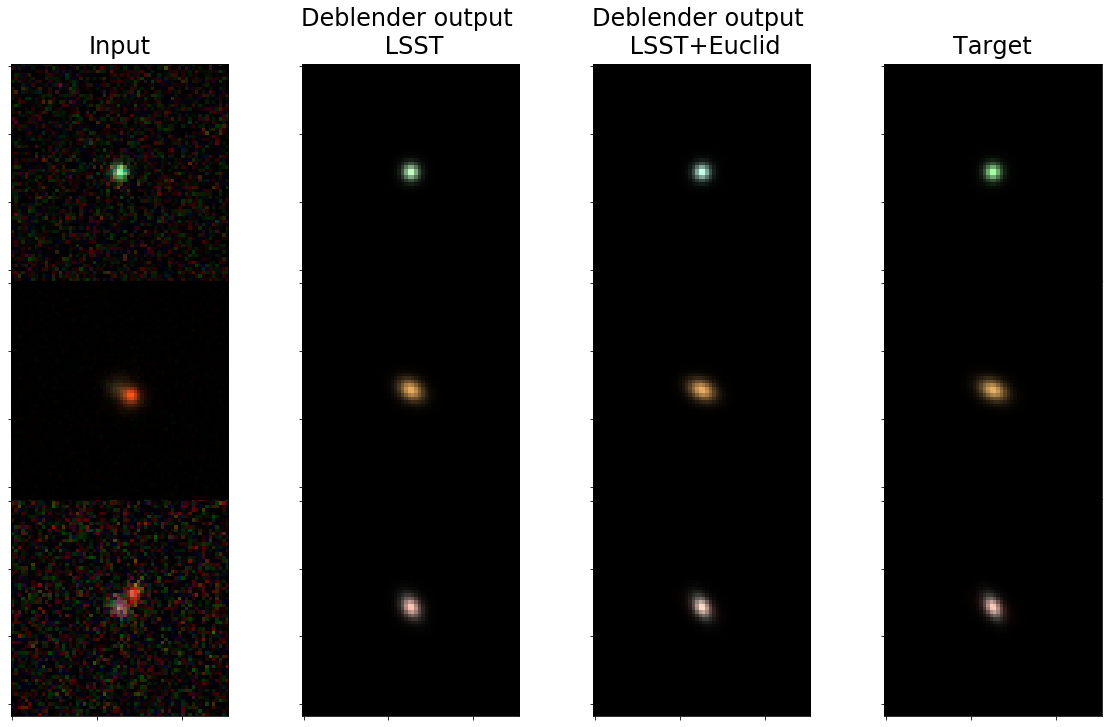

In [35]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))



####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Input', pad = 10)

ax = axes[0,1]
plot_rgb_lsst(np.mean(output_deblender[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST', pad = 10)

ax = axes[0,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST+Euclid', pad = 10)

ax = axes[0,3]
plot_rgb_lsst_euclid(input_noiseless[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Target', pad = 10)


####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
plot_rgb_lsst(np.mean(output_deblender[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,3]
plot_rgb_lsst_euclid(input_noiseless[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
plot_rgb_lsst(np.mean(output_deblender[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,3]
plot_rgb_lsst_euclid(input_noiseless[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [36]:
blend_rate

[array([], dtype=float64),
 array([0.53614187, 0.27017361, 0.28062558]),
 array([0.10091618])]

0.16652507 0.3


Text(0.5, 0, 'total flux in - total flux out / \n total flux in')

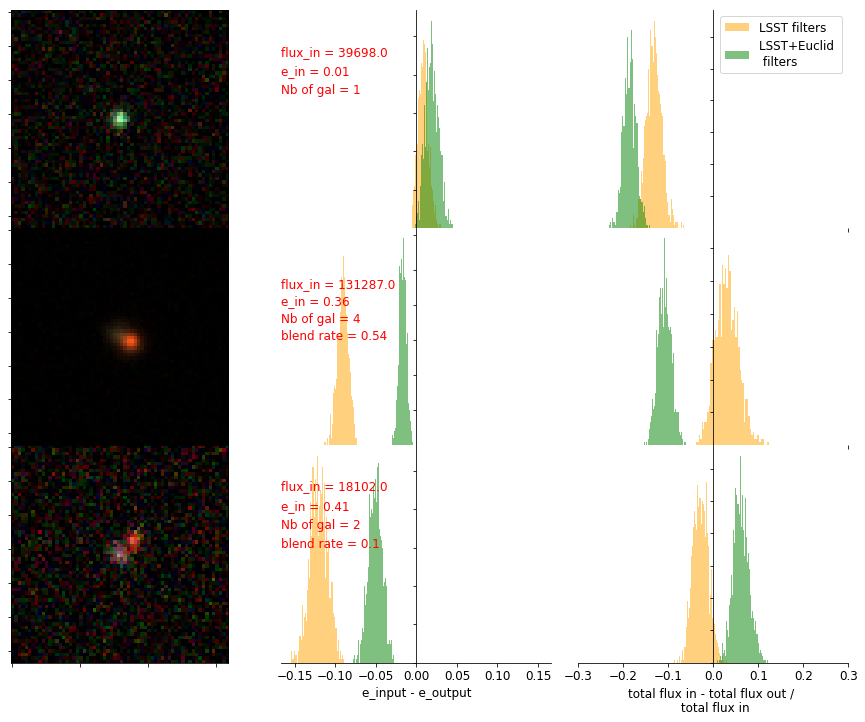

In [37]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))

max_x = np.max(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
min_x = np.min(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
max_lim_flux = 0.3# np.max((np.abs(max_x), np.abs(min_x)))

print(max_lim, max_lim_flux)
####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('Input', pad = 10)

ax = axes[0,1]
ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[0]- res_in_e[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[0])+1, 0)), fontsize =12, color='r')
if len(blend_rate[0])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[0]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)

ax = axes[0,2]
ax.hist((flux_out_lsst[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)



####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[1]- res_in_e[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color ='green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[1])+1, 0)), fontsize =12, color='r')
if len(blend_rate[1])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[1]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
ax.hist((flux_out_lsst[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[2]- res_in_e[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[2])+1, 0)), fontsize =12, color='r')
if len(blend_rate[2])!=0:
       ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[2]), 2)), fontsize =12, color='r')

ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('e_input - e_output')


ax = axes[2,2]
ax.hist((flux_out_lsst[2]-flux_in[2])/flux_in[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('total flux in - total flux out / \n total flux in')
